In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
%matplotlib inline

import torch
from torch import cuda, optim
from torchvision import models, datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report

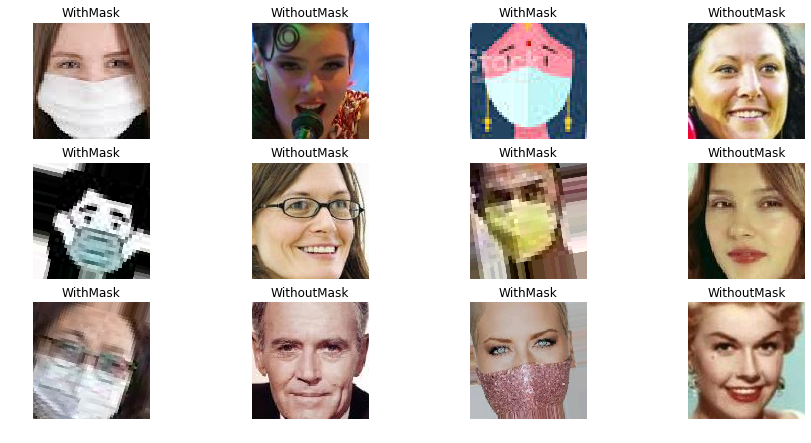

In [2]:
train_dir = r"Face Mask Dataset/train/"
validation_dir = r"Face Mask Dataset/validation/"
test_dir = r"Face Mask Dataset/test/"
classes = os.listdir('Face Mask Dataset/train/')
samples = []
num_samples_class = 6   # number of photos per class
c = []
for sam in range(num_samples_class):
    for i in os.listdir('Face Mask Dataset/train/'):
        img_name = f'{train_dir}{i}/{random.choice(os.listdir(f"{train_dir}{i}/"))}'
        samples.append(img_name)
        c.append(i)
plt.figure(figsize=(15, 15))
for n in range(len(samples)):
    plt.subplot(num_samples_class, 4, n+1)
    plt.imshow(Image.open(samples[n]), cmap='gray')
    plt.title(c[n])
    plt.axis('off')

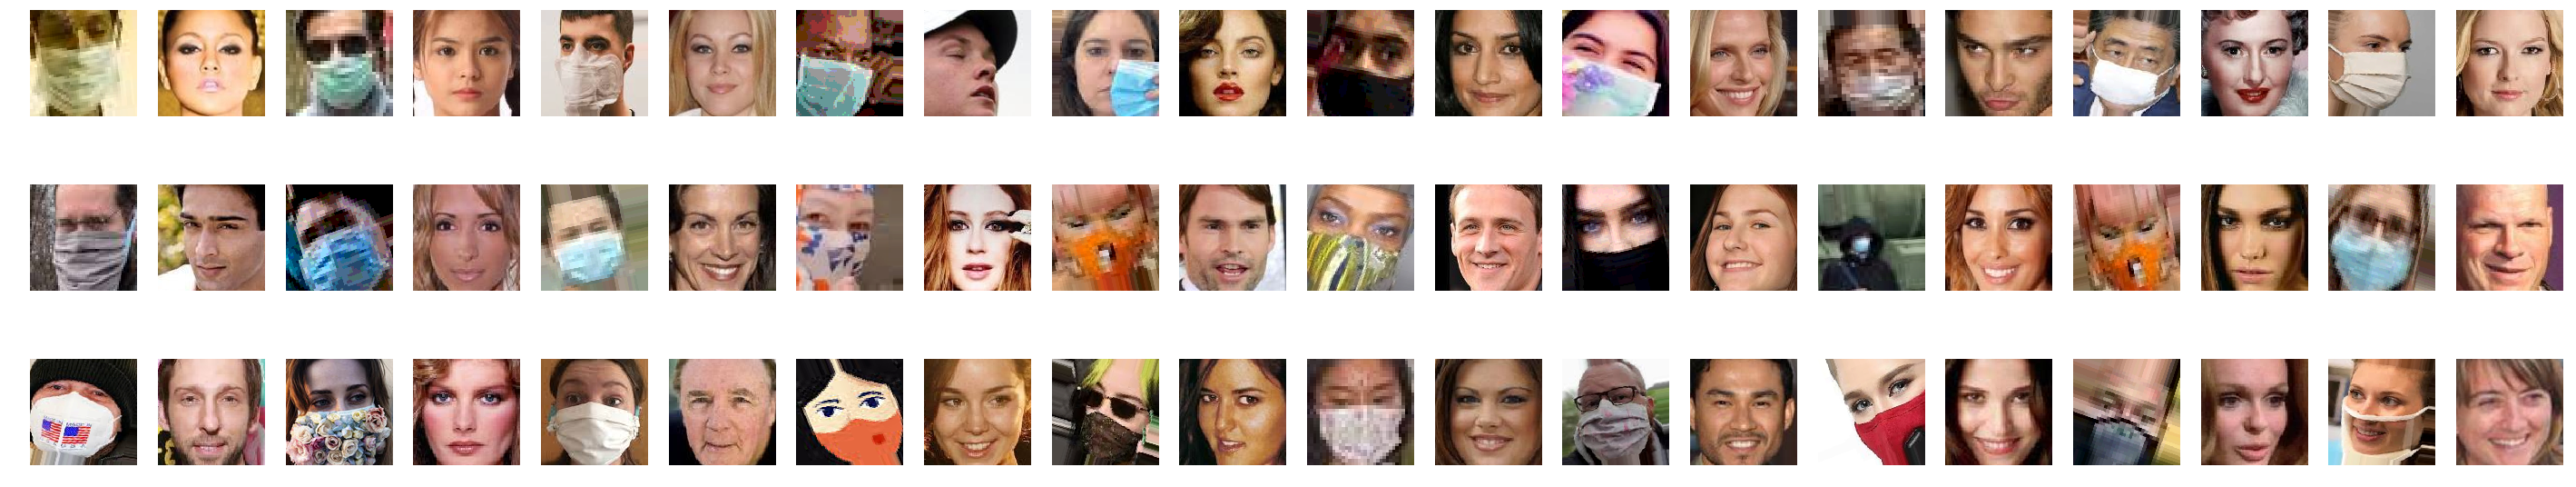

In [3]:
samples = []
num_samples_class = 60   # number of photos per class
c = []
for sam in range(num_samples_class):
    for i in os.listdir('Face Mask Dataset/train/'):
        img_name = f'{train_dir}{i}/{random.choice(os.listdir(f"{train_dir}{i}/"))}'
        samples.append(img_name)
        c.append(i)
row = 3
col = num_samples_class // row
_, axs = plt.subplots(row, col, figsize=(50, 10))
axs = axs.flatten()
for img, ax in zip(samples, axs):
    ax.imshow(Image.open(img))
    ax.axis('off')
plt.show()

In [4]:
print('Train Images:')
train_size = 0
for c in classes:
    train_size += len(os.listdir(f"{train_dir}/{c}"))
    print(f'{len(os.listdir(f"{train_dir}/{c}"))} {c} images')
print(f'Total: {train_size} images')

Train Images:
5000 WithMask images
5000 WithoutMask images
Total: 10000 images


In [5]:
print('Validation Images:')
test_size = 0
for c in classes:
    test_size += len(os.listdir(f"{validation_dir}/{c}"))
    print(f'{len(os.listdir(f"{validation_dir}/{c}"))} {c} images')
print(f'Total: {test_size} images')    

Validation Images:
400 WithMask images
400 WithoutMask images
Total: 800 images


In [6]:
print('Test Images:')
test_size = 0
for c in classes:
    test_size += len(os.listdir(f"{test_dir}/{c}"))
    print(f'{len(os.listdir(f"{test_dir}/{c}"))} {c} images')
print(f'Total: {test_size} images')    

Test Images:
483 WithMask images
509 WithoutMask images
Total: 992 images


In [7]:
target_size = (224, 224)

train_trans = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_trans = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_trans = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_trans)
val_data = datasets.ImageFolder(validation_dir, transform=val_trans)
test_data = datasets.ImageFolder(test_dir, transform=test_trans)

In [8]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [9]:
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, out_features=512),
                        nn.ReLU(), nn.Linear(in_features=512, out_features=1024),
                        nn.ReLU(),
#                         nn.Dropout(0.2)
                        nn.Linear(in_features=1024, out_features=1),
                        nn.Sigmoid())
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [10]:
device = torch.device("cuda" if cuda.is_available() else "cpu")
print(device)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()   

cuda:0


In [11]:
def train(model, criterion, optimizer, epochs=10):
    
    loss_over_time_train = []
    loss_over_time_val = []    
    acc_over_time_train = []    
    acc_over_time_val = []
    
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}/{epochs}")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader
                
            running_loss = 0.0
            running_acc = 0.0

            for data in data_loader:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                labels = labels.byte()

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1).float())

                    preds = outputs >= 0.5
        
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    acc = torch.sum(preds == labels.unsqueeze(1))
                    
                    
                running_loss += loss.item()
                running_acc += acc.item() / len(labels)
                
            if phase == 'train':
                epoch_loss = running_loss / len(train_loader)
                loss_over_time_train.append(epoch_loss)
                epoch_acc = running_acc / len(train_loader)
                acc_over_time_train.append(epoch_acc)
            else:
                epoch_loss = running_loss / len(val_loader)
                loss_over_time_val.append(epoch_loss)
                epoch_acc = running_acc / len(val_loader)
                acc_over_time_val.append(epoch_acc)
                    
            print(f"{phase}, loss: {epoch_loss}, accuracy: {epoch_acc}")
                
        print('-'*60)
        
    history = {'train_loss':loss_over_time_train, 'train_accuracy': acc_over_time_train,
              'val_loss':loss_over_time_val, 'val_accuracy':acc_over_time_val}
    return model, history

In [12]:
epochs = 5
model, history = train(model, criterion, optimizer, epochs)

epoch: 1/5
train, loss: 0.11537922968007625, accuracy: 0.9615
val, loss: 0.01699945390340872, accuracy: 0.995
------------------------------------------------------------
epoch: 2/5
train, loss: 0.060181975999753924, accuracy: 0.9771
val, loss: 0.045063017394859343, accuracy: 0.98375
------------------------------------------------------------
epoch: 3/5
train, loss: 0.05927644841633737, accuracy: 0.9783
val, loss: 0.011595757435716223, accuracy: 0.9975
------------------------------------------------------------
epoch: 4/5
train, loss: 0.050456849724892526, accuracy: 0.9819
val, loss: 0.016719216626370326, accuracy: 0.99625
------------------------------------------------------------
epoch: 5/5
train, loss: 0.03920305827236734, accuracy: 0.9851
val, loss: 0.012030102986318524, accuracy: 0.9975
------------------------------------------------------------


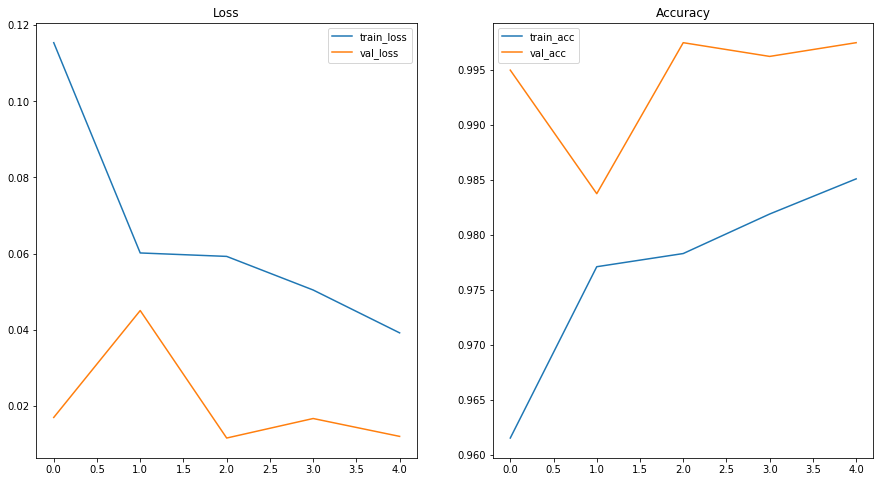

In [13]:
train_loss = history['train_loss']
train_acc = history['train_accuracy']
val_loss = history['val_loss']
val_acc = history['val_accuracy']
epoch_range = range(epochs)
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, train_loss, label='train_loss')
plt.plot(epoch_range, val_loss, label='val_loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(epoch_range, train_acc, label='train_acc')
plt.plot(epoch_range, val_acc, label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show();

In [14]:
def evaluate(model, criterion):
    
    model.eval()
    loss_eval = 0.0
    acc_eval = 0.0
    predictions = []
    labels_acc = []
    
    with torch.no_grad():
        data_loader = test_loader
        
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.unsqueeze(1)
            
            output = model(inputs)
            loss = criterion(output, labels.float())
            preds = output >= 0.5
            
            predictions.append(preds)
            labels_acc.append(labels.byte())
            
            acc = torch.sum(preds == labels.byte())
            loss_eval += loss.item()
            acc_eval += acc.item()/len(labels)
            
    test_loss = loss_eval / len(test_loader)
    test_acc = acc_eval / len(test_loader)
    
    print(f"test, loss: {test_loss}, acc {test_acc}")
    return predictions, labels_acc

In [15]:
predictions, labels_acc = evaluate(model,criterion)

test, loss: 0.009774432927388848, acc 0.9959677419354839


In [16]:
preds = [tensor.tolist() for tensor in predictions]
labels = [tensor.tolist() for tensor in labels_acc]
preds = np.array(preds)
labels = np.array(labels)

preds = preds.flatten()
labels = labels.flatten()

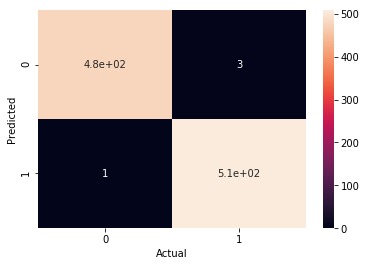

In [17]:
con = confusion_matrix(labels, preds)
sns.heatmap(con, annot=True);
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [18]:
print(classification_report(labels, preds, target_names=classes))

              precision    recall  f1-score   support

    WithMask       1.00      0.99      1.00       483
 WithoutMask       0.99      1.00      1.00       509

   micro avg       1.00      1.00      1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



In [19]:
torch.save(model, 'model.pth')

In [20]:
model = torch.load('model.pth')
device = torch.device("cuda:0" if cuda.is_available() else "cpu")
model.to(device)
classes = ['Mask ON', 'Mask OFF']

In [21]:
def predict(img, pil=False):
    
    if not pil:
        im = Image.fromarray(img)
        
    trans = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    im = trans(im)
    im = im.unsqueeze(0)
    im = im.to(device)
    model.eval()
    output = model(im)
#     print(output)
    pred = output >= 0.5
    c = classes[pred.item()]
    return c

In [22]:
import cv2
from urllib import request
face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def img_predict(img_url):
    req = request.urlopen(img_url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    img = cv2.imdecode(arr, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     m = 10
    img = cv2.resize(img, (224, 224))
    temp = img

    faces = face.detectMultiScale(img, scaleFactor=1.4, minNeighbors=3)
#     print(faces)
    if len(faces) == 0:
#         print('No Face Found')
#         plt.imshow(img)
        c = predict(img)
    else:
        for (x, y, w, h) in faces:
            fc = img[y:y+h, x:x+w]
            c = predict(fc)
#             cv2.rectangle(temp,(x,y),(x+w,y+h),(255,0,0),2)
            break
#     plt.imshow(fc)
    
    return c
# img_predict("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxASEhUSEhAVFRUVEBAQEBUQEA8PDxUVFhUWFhUVFhUYHSggGBolGxUVITEhJSkrLi4uFx8zODMsNygtLisBCgoKDg0OGhAQGi0fICUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALgBEQMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAEAAIDBQYBB//EAD0QAAEDAgMFBgQEBAUFAAAAAAEAAhEDBBIhMQUiQVFhBhMycYGRFFKhsSNCwdEVgpLwM1NisuEHQ3LS8f/EABoBAAIDAQEAAAAAAAAAAAAAAAIDAQQFAAb/xAArEQACAgIBAwQBAwUBAAAAAAAAAQIRAyESBDFBEyIyUTMFFCNCYXGBoTT/2gAMAwEAAhEDEQA/AL9qeGqNhUhcvNmpQ0hPYUgQmjVESTBSAKEuhdbUXUdQ8uXRlmo5XLl8NRxV6IlpFXtKvmmbJdJQV5UkonZBzWi4VjKydzL7EuhyY1OCoUXSSVwKNzlzGpolImLkBfHJE4kHdFOwr3IVlVRK8HNdxJwYuFq9DHsYz7iLkxpkpPUljSkoM01CDYWOLlKi4sqUBTlyYDAXNV51vk22bOOFIkDk4OUcJwKig6JghNoVIaiWuVLtevwRYYcpCJugGjVh89Vo6RlqyYOa0ey6stVnqo6TFYpbCHBNUjguBqp2WyMrkKUsUbzCk6zjXwUzadHE2UnOU9LeEI8cnCSkLzQ5RM33ZSV18Ektb95EzvRBqNRSkqvtKkhGgrDnGmai3smaV0KDEk1xUKIXEIc5NCjenUpRJaOJGHNB39bJGPEDzVHe1syn4YWyvlkBVnyUdsk5qnuqsBWPZ10lX8i/jZVg/eaIOUgTQ1PAWXZpIaU1zgBJMAZkkwAnXNVlNhe8w1okkrzzbW2qly6BLaYO60HXq7mfsmQjy34OvdIu9r9rWNltBuN2mIyKY8hqVnK19dVc31XRyacI9gla2nRGi1KJzr4jVhv5bKt1J/zn3KkoX9emcqjvUlw9jkj3W6ErUEcM8l5Bn0sH4Laz26HwKgwn5h4fXktTs9uU89F5sWEK22Jt59HdO9T+X8w6tP6aeSfkyyywoqft1jlfg3T35qWmUFaXTKjQ9jgQeP6HkUW1yqNVoteCYuTSVGSn0Rmgqjux2u/C0nosjUvcTz5q97QXOFkDislQ1nmr/R4bi5Gb1GWnRbSrLZFeDCqGHJEWtSHAo8kbi0DF0zUPemF6Y0y1RvWbx2aMHaJzVUb3yoQ4pSp40GkdlS0HwVCSuYlLRzVotMQXVX96updMT6RmbCvorYVFmtnVdPYq/oPCt9Vi4yF9Lk5RCMSkYosQUjHKpRbOvKnt1AXLveQFNXoCWkc2jcZZeSz9d8lF31aSqys+Ar+DHSM/LIAv3kmFf9mmwFQOEmVodgK51EeOEr4XeU0YTmlRMcm3ly2mx1Q6Ma5x6wJhYdGwZHtrtIvqfDtO6yC/q8iQPQH3Kq7K1Cgty55L3Zuc5znHqTJVxaMhPlpcRmKPkIoW2WiI+HHJE0GnUlEPdA4eySWLKmpa+fsFX3NvHVaN9VxEYR6T+6DuLcOGn6IkiORnXM6IKpT+iu7m3jRVbm/dMhYuf0P2VtF9B+IeE+NvAj9+q9CtqzXNDmmQ4Ag9CvNKjOK0/Y+5lj6ZPhdib5O4e4PunTXKNlVe2VGoc8KSm6BKCGZhP2hWwMPkkONtJE5ZUii2xWxvhVr2wiGZklcqsW9ixqEEjEyy5Sskt3SFIhqEhFFVskaY+DtF7sutLY9EQ8Ko2bVgwrSu7QrMyxqRodPLwLJMcmYkg9DRaOpErjimlymjmdxJKPEku4HWZCiYKuLasqmoxFW1Ra/V4uSsw+my8WXLXKZtRAMepRUWQ4G1GaaCu8TK9WB9FHTKhvXwEUY7EZpgVd8lBVzKme5RUmyVqYIWzMyy0MLMlf7AbkqasrzYPhU9d+IHpPmWo1VH2zuMNvhGtR7Weg3j9grhzs1mu2D5NEQTnUdA4ndA+5WPjXuRtS+IFs+hkABwV3Z2nRZ4CuPC6HcgJARVOteshxMicw4EecGB7LnG/IcZ8dUaplpAy9MkvgnOOf8AfVC09o46bTocXDzhWD65/pHqlUrG8nVjH2BHhHn/AMIG6pYdQmXO1LoEYCGiBM5mUPUq3VRu++BGopu+/D0TeK+wObvsDXDgQRKqa1ODI/40Vm+k6Bi3hwc2DHsELUbwPp9kcdEy2VtTNF9nq+C4A4PaWn2kfUIeozNRsq4Hsf8AK8E+QMo4vdCcn2eh2Qkyu7TsnVMgUNQrYUU2/QVJS5IROLkC0thGNV13Z93NGt2nCf8AxdWV1eXyVX0iKw7AfzS/gr+asv4v0Xf4n0QTz5GFHBRVt2c9plGuBwpz78FRvuxCTJzl3Q6EOJAXpoco3OSlHRZsIDkxz1HK4Vyic2SY0lDKSniDyKVzMlGwQiCEzu1vSjaPPp7J6T1K0oVmRRLDxWNmhxka3T5LQS10Kvu6klTVqsBAOcoxQ3YGWdiIkoynRyUNtT4o2Fq4o8YmfOVsr7hquthjdVXcU1bbGG6q/X/iHdJ+QIrPzWd2u8Pqgf5bYMji6Dl6Qr2u7eVDckOqvMZDC32H7krKeom0t0UFS9uWhz6bQMLx+XG9wJMnyGS1ex7urVtu9qEB0kCm5uF7mgCXQCeMgAjOJTbe1ZrI55if1R1a4wt3TwyOg9AlvLGqoJYZXdlXQeDWESGkBxBkZ+XBW1e6lxAPA6KmshiqF3AZTzRlR0uBS33Hxjo7dmoSA0QMBOJwOGcMgZazpwCqNkbTvahwupBgDHOJfTexpIMBrXTJny4LU29LE3LPpP2UucRy5y0+4/ZHCaS2hWTG29Mz9lcPcTipuYQd4Ogg9QRkfoU/adEZERlrEQrSszll1yKCuGbuf009uC5S2Hx0Z+uOKDrjUDPIHojawzIPAlQ2dMPcSfC0e7id0J6+xL3ov7LazCKbXSHFrQcobigSPdHlyrHbPAfmcRFPEOQInTkMlaEIoSsHLDjRHiXQ5IhIJtFayRqdKa1IoWMXYRK4uFIOXHHZXZTV0lQShBy6XKKUiVNHXodiSUaSmgbBcKf3afhUoYttmGBvamB8IirTQ1UKp1GO1Y/DOnRFVfKYwSVxF2dFKwwth5JaCqFOApC1PwpQrxWB6jVYbNG6gqqNsPCqXX/jLPS/MHuHbxWcoVZc6eL3x/UVoax3isw4YKz2/wCrd/nOIfePRZsl7TXg6kaOzpyOqg2pWgFgmYzjhy905t0WDC0S6M+Qnmqq47zEc/FBJgO0GkSOSrqKbLcnovtmWThTybOWcCUyvQeTk0obZ21nhsGQfCYnCf75IouuHR+KKbTnDWd48+ZJACn0/s5TQRsi4wuLXjPgRoVblzTwlZ+1DxULnkaRwE+kmEcaj27zRi6TBUdmcya5ZGYVPdO5I24uMYLmTIyc06g8iqe7q+Fw45HzC7yTeimvH7x8la7AsJaCXEQ9pEZEuIkfUR6lU1yMz5rQbOZNFnCH4j1gRA90+b9pWgvfssb+iGOBH5mub1nKfLIlLEq8Pc55BJyc7XPirBtEpmJJLYrqcnKWjiRTu4K78O5HaK96GgruJO+GcufDOXWglIbK4Cn/AA7k0UHKLQXIS4XKQ0XKN1Fyi0G2MJXMSRCaQjAY6UkxJcRbJAETTYmMYimNWxJmOkDvpIWtQlWpYozSUdySjbb56KzoUYCI+HClDEMYqPYmTsEc1LCiTTTXNRgANYIyz8CgrBTW53FS678ZZ6X5AFd+8VTX8d+082MPq15/Rysbh28VW3436ZOkvYf5hI/2qk4+w0IZPckG0ycBdzlxVfSvAXSSOUIzZdQFjmu/K5zTy1VTXsGU6weGYmzOEzhSIRV0y1JyfYv7CuxpO8M+Ex90Wys2ILxrlnJ+idY3Vi+MdpEST3dQmSTxEhW1Grs4AYLRzyDJlgPA6lxg6pnBfZz5L+hlC+syZxj3190+jtDm4D1U97tS3fussGSA4bwYAJPQdEHabObiNVzGhx+VsNA5AIJRigrn5Vf7Cq0kteNS5rHQcnNdln65qruaYDX9KuXQQD+6sq9ZrCCRk2anEDIbv1P0VfWP4InxPJef5jKT2DTsprvU+asNm7cptpmi8RG8x2oziQeWirLt2ajFOWk9FZUU4qyu5NSdFpabSGOZ4rQ29+DxC88oXjQVeWV+0p/ooz3lb2bAXreYUjb9vRZz4gJ/fhQ+nTI9VmjF+zol8ezos2a4S78If2qJ9ZmjN8zom/Gs6LOGsFzvQu/bI71maP41nRKrXaRks8SiKFZQ8CW0EsrYRV1UZcpKgkIeVMR3IfK4mJIiLLQKVhUTQp2LWZkkoXCFxpUkqAhjQpA1NBT5XM4jeFA8IgqN4UoFgFYKWid1NrhNZ4VU634FjpvkVVwd4oHaYJpmNRDx/KZ+0oyu04jkoK4MaKukqHXsrrG5/FPJ7Z9R/YVpRAdrwyWYe/u6g5TI8uIWht62YI/MB7qpkjRfwz5B1O3IO6ftKMt3VdJ9oTLTl0RtCm504TkNTxQKTLLv7ITSjMgJCoTpoPuo6gOYn9EPdVw0ZHQeiHbObpEG0KwqVG0+AMu8hoPdDX9zJ6DLLRCOuYJcTmZQVWq45DUo+IlZKGwXvy0CNq08LY6GUbY2IYwHjzUV/ofJdzt0g1CotsY7s1hdBHAEciCJBHSCj7LYIBWgtbcVrK3rMdkwPpPBGeEOLcurH+4BQuy7oOe6k6BUZqNA4fM39uC3ISUlZgSVOh7NithcdsUK5YE4oqIM+7YwUbtkLQOCYWqdEGbfspQmwIWkfTQtamuaRCso3CMl1hU10yFA0qlONMsRdoOoPyUNTIpUXJVgq9UywnobiSTFxFRNl4FKFG0KVq1DNOhOc5chODVJxGCiGqMMU7WqGciNwUbgp3BROCglgVwE62A4p9diq7t7m6JHU43khSG4ZKMtluLamV2pYMIWdG0HjimXO3u7bL3ADrx6Dmst9Nk+y360Ct7XbNaHU8Jz3zA1gRmq7Zd9/wBt5hw04T1CGpbTfXruqOBiI6NHAfX6qe+sw7ejrlqOqlx41GWx2N8lyiaayvgBr1VgNqRphzEZidOi88D6jPzGPMypG1ydSfcqFj+mN9d9mjX3O1mCd6SeslUl3fl56IKm0Hj+6Jo2+ajSOuUjlKlObszwCNtLef3So0XOMAfuri1t4HklykNhAc0buaq7wZEK5c3ogXWpe9rW5l7gwDqTA+6XHuPl2NnsumKOzKLY8een+bULzPpKwm2SRWxsdDwcQI8Q1j7H6r0jtIG020aQMNbkOAhjMDfq4LyftE11Oq4tLmh8kmYZI1iAIOp9FuY3wiecye6TNjsPtCyse7fDawE4dA8fMz9RwV2vKLS3NcvxatIcxzCRB5SOMhbPY+3nMYG3EmB/iBs7ukvGpIyzA46cU5S1YP8AY0ZCYlbXFOo3FTe17To5jg4e4UjmorOIiENWYiHFNK4gqLuiquIV/cMVPdMgykZY2rGQeyNhRLW4kHiRVtdBuqpzTrRZi15HfCOXEZ/EWJJPKf0MuIcGp0LgSJW20Zg8BdTAnAqKOHtUoKiXQoCJISwrgXQVBI19KUNWsgVPc3dOm3FUcGgcT+nNYXbXbKrXd8PYscHE4TUcAH5kNAYJMajeOnJDKaj3JSssdv3FC2aS6XuESxkFwnTF8s/3oV5vd3L6zy98SZDGgyGDkP34qz21Ugig0QKcB+9jLqxH4j3O/MS6c1S1aYJGeYmJlK53G2TVOkbPsPsWk9uGprVrNpN5gyQ0jrOfojWWbmksMSC5ruUjI/UKu2HUFEUqocThuKBGZE7+c+RHHXehbHtFZGlcvIG5VPf0zwh+bh6On3Cz+plyVpdtGh0SqXFvvsy9xsoHp0CEs7FpyI0K04pg8FVXdAsfi4H7qtGb7F2eNdztPZTImJPCDHuUW22by6FcoVgRBKIYZ8v70QuTDjFeDllQ3tOMjmj+7XLZg1HHX/6ig1A2MSBXtVp2Q2djuO8Iyotx/wAxkMH3P8qBrQAt12b2b3FABwh7z3lToSMm+ggecp3TQ5Tvwiv1eTjjryzMdtKrH1HsdJ7ug0kN4FziczBAnd15Lz+o4HCypJaxxOIg6Q4Nafm+uhHBaG/2011a5BI/EqOmWHFAhrBJOWTRwg/RZu9uYnKN01A3MyBpBOgmR5eavLqJW6Mh4kTVe/P4luCWFuIYe6wuPPCRJ80Xa21bDTqVH4ajahJawnAWzOBwBgyBE6qpsNqBga3hgwkMGYgAtPUk69StJa3LHw0neDm+Tp0I5ZHRNhlUrUtAOFbRRbUm0uGikXNa8mq0UjDwHZuZi4tBJygwrO27T3VPOpTFWnlvYmUqw6mAGn2Hmsy6jVq1Ov5dZJABgdBH2HRX1v8AENpuDwM6WJmOAd0yZ6xGfDiuwpxVEZHbNPabat6sQ/C4/lfDTPIHR3oSjixeabKvmuGAtDMbtypH4Z5FzDl55jVanZAuaT8B3RlhBLqtu6fkneZHKYz0KsRyWC1ReVaZQN1ZkhWbaw/OMPWZZ6O/eFPhCZpkGUOz38lG6wqclsBSHJLuRyQ8Ik2zHfBVOSS2PcDkuKOETrYCCukpgXHuTM+VYoOb8AY48nRKCntQoeVM0FZUf1jHLtFlp9K15JpTgoWgqq212lt7WQ52OpEinTgv/mOjB1K0cGeOSHLsInBxdF9IH6rO7V7TAbluA93zuypDqPm+3VZ+x2tc7QcS4BlBpza3EGO/04tXn2HRUvaSnTpVCykHlxgAu8A57xzKmU9WgfNE3aR9V7m0+8dVquzJJENjeho0GnREbGsfhaD7txGJrX9zp4nDCDi1Ikx7qPsnsjvWSHbpnvHgbxPFjevM8NM+Bvby4FKlSt2mYh5xRk1uTZiOOWnBKaVcmSm+yMhWdBkmSJLjxk6n1lMtgS/wyCCdY5GARoU1ji5hLvmGimt6UmcUZ7pMASBx5Ezp90jKxsEXLmVe4LRngNN4cSGmA+QIynU+sr2i62d8XatA/wARgx0j6Zt8j+y8h2TTL7epTcwPDqZGPvI3gSd2deWEcDovZ+zdT8Nh/wBAP0SoVJSixtuLUkYVjCJBBBBgg5HLUFPrUA4LebT7P07gl04KkeJoydHzN4+iyV3ZupPNN4zHLQg6EHkqGTFKH+DWw545VruZ74WD6oph4I6rRnNB12EZhLux6iF0Xaf8QiVV7PrEuhW1vbvq1G02ZuJgTkBGZJ6AZrqt0jnpWyz7M7N76ticNykQ53Iu1a39T5dVqe0V93FtWrfJSe4aaxA+sIjZVmyhTFNo0kknVzjq5Y7/AKwX4ZaMpDxV7im0NzzDDjOQ1EhvutPFj4Qoxc+X1J348GDrV8QYA0F1Vry0NaJJ8RaI8UeecGJVVcObVa4h0nEQ/AIc35w0TygYc/DwznY3lqBRAO8W03VQHAuhwnDAGYyg5c1nK1k8uDgMLgMYfSfTaXB0Cd6RO7qRnplCVFUgZOymtZYBm0ObvS4OcYOYGKMzEACM5yKu61wXsZVDHhzcIeHtDAYMh2EzJzjqCcsgiKGxq1UEuaGQAaRrObWAOhdDHDUZ706EIzadoKhdTxZBrWjxuJAI0knMCBGale6VIj4ogubKoGB1MtBwtOHCZw6ka6wXe6O2dd0nOIL5fjO5LHBsnOYJkTl+iguKmBobOgwdcpH6BMtWtaBUwFzvA1tNoxZ6/lM6DWAtGq2VLsG2n2UY8mrQ3CQQ6nJ7rEMjHFumo5BaPYFFzLemx7i4tbhcXa5HT0Q+ybWCXHGSRG9UJA0GbZ1yGueSsK9zSpCXvDRmZdIAAiSTwGY91ySW+xNt6Ito3dOmw94/CI1BII6zw0VRY7Wx1AKD5bBMCox2KAJljt6M9WyeucInatEVgHUsNTRwzY5oHAiSJkacEBT2LiqAvYGiBLvE7XMNjQ9eGUJeSHPcXT+woT46Zd0duYf8Wm5vMtZUI/pLQ4fVWlpe0qomnUa7yOfqNQslWtbhtSq5kDdyLXVG45zjWMQ5lpTNh25rYnVgRUa6GF7KfeNg6sfhzEefHqFEZ5oumrDfB7WjcQkqX4Z3+bU/rZ/6pJ/OX1/0DX2OUNdySSD9R/8APInpvyIjZUUG0O1FtQyLsb/kpw53qdB6pJLF/R4r3FzrHVUYna3bW4rOLGTSbyYd4/8Ak/X2hDbH2aypUwPZI/xHBzjmZzLspJ4+SSS0cuSUdIrQipdzR7R2zQo0wymWggBrWAgEchCxD7nG9xfmTOcxn+0pJJ0MrnG2LcFF6PTOzd1SdTDKYI7sNbnxGmIcwsL2zq97cvdO62KY0GTdTn1ldSRZH7AYL3FPWALMbcpJxQIAzOHpwKJs7ZlSNBFIOIGUmTIPGYSSVePcczWbBpijTrhrfFR3csRBLZG9AyzHVepdhD3lrTJOtOnnz3RP6JJI+Ci3RCk2aXARx0WW7Z0t+i7iW1GnlulpH+8pJJGdfxstdK/5kUL2kJtakCMh9lxJZnk2ir2W38R88D5rW9imt+JqEnMUjhnlibKSSfg+aEdVrEzdYmREk+hJXln/AFEY6tf0MLgW0qZBbo5pc6XO9Rh8o6pJLQfdL7Zi1psFvKtYhoLcIBDHEHETMCcRzPsI9FV3ZqVHTABAGQDZAObWjKTqT6pJKx6cUqoRyb2W1LvngBzQ1ogbu6SNdJ5j6ofadsWNdVaMTmtylxA65DoTrz4JJLo4oLaRzm2Ut5eSA8iA/E4dN4q42LcNwRjLSdMIxOy1ygpJI70DRHU2rWY6o5rGVcLomnOIgA5O+V/TTryio7fpXWKmWgODe8bjGUjxMe08RlHPhBCSSVJ3S+w0hbO2XVpVm1BUGHMPgOBwaRHEZCPIELnaXaFzRrNLHgUiwwGhrnueDLpkGMoyEZSeGSSXSjxg6Oi7lsH2W25DH1KlTuwHgNc93ePcHOGUQXEx0E9OGo2XVpvY1zB/pzEQW5GBwSSSunb5NB5UqDcTeYXEklasQf/Z")
# img_predict("data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTERUSExMVFRUVGBcXFxYVFRUVFRcVFRcXFxcVFRUYHiggGBolHRcVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGi0mICYrLS0vLS0tLS0tKy0tLS0tLS0tLS0uLS0tLS0tLS8tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAPoAyQMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAEAgMFBgcBAAj/xABIEAABAwIEAgYGBgYJAwUAAAABAAIDBBEFEiExQVEGEyJhcZEHMoGhscEUI0JSktEVM1NicvAWJCVzorLC4fEXVII0k6Oz0v/EABoBAAIDAQEAAAAAAAAAAAAAAAIDAAEEBQb/xAAzEQACAgEDAQUECgMBAAAAAAAAAQIRAwQhMRIFEyJBUTJxgcEUIzNCYZGhseHwQ9HxUv/aAAwDAQACEQMRAD8A1pNuclkpAagGi2pyyS1dJUINvTTnJUjkO96hQsvXCUyXLhcoQUTquLy4VCjoCVZJaUJi2MwU4vLIxl9g5wBPgNzwUIHZV7KqPU9Og11x1bhcaNLnEtublp0Ggt49yB6T9NXSNDaZ7oxu99gHEC1gzNfLvqSOGilFWjRd0u11klL01mYGAvzkXuPvjdoNhoRY+Kkqfp9I1gLma3NwG3bbhZ3NSi7RpWW/gEuypP8A1BgbE0m7pXWAiaLOzE21cdGt7zwCl8KfXvHWyOptb2gayTQa2BqC7U7a5Lb6KF2ieSgh6KpEjGvbcB3A7ggkOad9QQQe8IgKFmEekQBldU21Lrey7BdbTQ6wwnuZ8FjXpMd/aErSALBuvEgtG61fAp70NO6x0ZGfcEyfsoy4tpyJsoepqms3OvADUnwCZxMyllo3BhJADi3Na53suUWHhgGZzpHcXvtmceemg8Almi3dA8jnyesTGz7rdZD4n7KT+jYf2b/xO/NSgYBsF26llUvMJXLpmKe5RJYraCTT4E5klz0sRJTYOaosGcmy1GSRDgh3NUKGC1cATjmr2RQoTZeLU4GruVQsCr6psMb5HmzWNLie4C59y+e8exo1c5mcCB6rLkkhtzYEjQnXkte9JeKRspJYDIGySsIDdyRsRpsCLi+nisPkeCLDZHFCpvyFsfl1+KU+vcf9kNCC5waNSdPNaVh+FUlPEHva24Grj2iSdLAcSSbABDOaiFjxuRnsMxJubgDf8glz4mdLaW5aBWjCaUVlTJLIxrIoiWsjFrZ+RtuRuSeJHAKbm6F0z9cmU/u3CF5UnTGRwSkrTM1M2Z1yVo3ox6ZdW51LUPJaRmicTexG8ZPsuPaOSgekHQZ0TTJC4uHFp39hVVpZXMe1w7LmOBB5EHfzRqUZcC5QlB7n0fgV+sn7BYx5ZK1pvo+XOZDtoXWa8jg57vEzBdYEnYKjYHWsmp4aozVTpAG5gwyvOaMkSM6mMFtrgt1ab5tLmxF0uHm2thYkEW1IuAfDihDMN9JdXHJXPczMbtaDdpaLjlcXItbVaV0Fq8+HxfVus2Nov94t00v4KiemCnArmu2Loxf/AMSfzWh+jt18Np/4C3yJCbL2UZofaMnHAvtpYXB1307k/Zch9UJdko0iLLuVLyr1lZQzRxXNzwUkhKYWRJcrlyVBUhYXimi9J6xCGPZUw+NKzrxcoQHLUkoghJyKFEdida+JocyCSbXVsZZmA4us9wzeA1VaxDp3JEC52GVoZrZxY21hxcGk5fbays2K4zTUzM880cY4XcLk8mtGrj4BZZ6Q+n7KiP6PSl2V2kklst2cGs1vrre4GmnG6JAydeZUemeP/S5zKG5bgNAJucrSbX4XuToNFWi5Oz/7J3C6bPIAieyFVbJ7o3RtYwzS7Dha5N9AAOJ4I6sfNPO2FoyyOFwLgiBhIBe4jeSxG217blO1LmwNDnDMQMsTOGa29uffwHioGCrkjc4iWz5NXnS7jyuOA5bLMn1OzZJdC6TSsPwdkEbY2bN8zzJ7ypSOM81lBxeqjIIk/wARPuKtOA9KZX26yx01sLa666IJY2txuPKntRaa3YgrLulFGI5swHZk0I/eH5j4K9U/SiB/1chyO212Pt4KrdPmANYWkFpcCCNeDrq8VqRWdqUCxeirGjHC6INe92cu0sW5bNGlzobg/wDK1ugj7DTxdrr36r586BT5auON0jow9waHMy6mT1L5gQRmsNvtLesJjfE1sT3ukJzOa8tsT2sxa4jQOGbuuBfmA98mWPBmvpsitJAe5w+Cs/orF8Mh7nSD/wCRygfTdH/6c97tfYp70Ru/s1nc+X/OUz7gn/Ky1wRaW5EohrLLjTqUolDQ2zlgvWC8vK6KsECWCkWXUQtOjucpbE3ZKAKqgk2FNsutsmGxlGxxABAxiY0Qq705gqHUchppupcxj3kiN0j3hrSerZlN232vZxHAK0myjccxeGkhM0ps0Xs0ave4AuyMb9p1muPgCTYAqi7Pm51J1cTpX0sjjmfF1sjTHEyRpLS1jGWBl0N8xOW2xtdQb33Pdf4nUrQOn00mb6O4M+l1LzNJG0NApoXAOZA517B5DGyPI+6CS6zSM9boQExCGgymid+sAGUGxvxHHQ9ymOj0DeuJGwGnwQdFQdbBdrrlpJLNiRfhfTZE4dUATWGgII02tf8A4SZu7NMElTZc6DDGSzOkmsWhoZEwcjYve48zsO4HuUT0g6DkvLoB2T9ku+BIUrSutYqw0s4ssym1wbHjjLkzp/RmTI1gZly7vJBuCdnWttsOKveA9HIo6UhrQXFpu8i7ieY5KE6T9IhE8jJmAF2tN7OPE6b8BbvTeA9PjlPWhrGi41s0C/DvRPrkrYMVCDpFI6sSPLHuyuaSO8nkOF+5P1MTnthpy4ZXSAh3HtDKdD52Vqr+jglBkj2kBOwvZ2tg5V7GMFIa7tjPAx0ha7d7C8AkHmN7eKdCak1RmywcU2wLFsOMM08bHG8GW7huC10bTY7gB7rA+C+k+h2JfSqGnqD60kbS7+MCzx+IFfNLnuED5SbicviJJOa7TFNqe85PGxW+ehx5OD09zsZh7BPIAE0SuSA9ORtFTi273a8rAfmpL0Nsvhx/vZPl+aF9OA/q0Wn2/wAk96EJgaGVv3Z3e9kZ+aL7gv8Ay/AvPVa+xcITrjsnI2obGtDTISUv6P3p0vCb648lVl9JHZV4NRjxwScoCLqA6DkdNzT5aALJOdIMiHdhpJDrWhKLkwHpbRdQsVcKu40XSuZm7ELJ4bNNgZpGTBznOvtEwMc4cXFt9A0ZrF1So/pVq2xwt7QaWxVcrTfXrOqFNHb/AMqvzy99oimYxX48ZKitqxbNUNkY3S4DJnNboTsepDmg79pVsc0fV0xZFG7W0rcw5Xa5wsPYWG37w5oCRMQlh1HWuYcm7Xa25HmnKSX6y+gTFEzNIB4/BKnGRyW0rGW6LXh+MbN5aDmd1MS9IWwAZtTyH86LP6WpsbqXoo46h7jMSALW110SZY0nZohlbVLklcQx/wCkWAZGGX3eA7yzfIKPOG6Znhjoi5vbYWkjX1sm4HDUBGNnoYjlMGcbEuJc7xBJu32FeqaSnyOlo5JHAXzxOs6zSLHLoHEi99b7KXQzoT3u2XGnIZG1rT2QBY93BRvR5zJ8Wkgeey6lkaRpYkhwIIO/ZkJ9iiMBxX6gdYbZOyCeQAt/Pcho5H02MQva0OfMxnVhw2dURGJh1+6878gbXuqxQqTBz5E4ICpow7B5wfXhmppbabSCWAm2/FvuWyehdx/REN/vz2/91+3tusenpHUkWJ0krQHhlGNDcdmaNwIPHR4Wy+iaPLhFMDx6134ppCD5LR5GVckf6bH/ANSZ/eAe4n5IX0GSXgqW8pQfONo+SL9MsWahab+rID/hcPmob0Eym9W3h9U72nrB8kX3Rb+1RrHVp8JDXLubRAPKl0zx99MLtYXG+mtgRyJ4Ko/9SZP2Q/Er70kpKeeEmaxa25ve2Ui9zcbcVjeTD/8AuJfwj/8AKU07EZZTi9mb91KV1adBSSmDwaWNNWRhTD2okwWhsBPsK4yK+qUyNRkR4vWX+neMCljkvcukbDbk2z5nEHmXRx3/AIVqOTVUz0q0rHUcZfo1s7CTwAdHLHc3/jVLkj4MQ6VBgMDI9GspaYncAySQRyPfY7F2YXtva+91XsvE7Df8kW6UlrS65Ia1up4NaGtHgAAB3BDzjn5IxYRQk5g8H1Wknzy28jdGYjTXaHDWyFoo3BjncNARzBI181MyR9gDuSZypj4RuO5WmuUnhtRlOux38O5A1UOUplklk3aSEbxZP19PHux2p7tkmgkdCc1/yKimVRS2yF2g8kPRtQfeb2S+G3qJ4YNfrZGtNt7PcLnT2q0dKpGHpFSRRn9Q+jhJAv2mvDiLcwHgcdlBej6O2LUrXA3bIXEHsmzY5HbHba9lO9CcJfU4hQ17mk/SKisqX3u4NZC5ojuRoLSEgba27ldJFXZG9OP6xiGJSMPYiLBfSznRBkJYOZuJHeEZWw+jJh/RNJm36s/hzvy+6yy3H2Mp8OmpRc1M9a6BzbNJd9HmfMHh1ruzCeBup3I2N77X0dw809JT053iijjPe5jAHHzBUZceSq+mSL+zXW4PZfw1HzVX9Ah+tqx+7CffKrl6WWXwyXuLT5OCyf0X9IHUlU+0ecSssQD2uwS4W8yruosXLaaZ9EHRR2N4kKeF8x1DRdUfFvSiy1o43NLSMwkFj3gAfFUHpnj805I613VuseqGjRbXXmldabouWaK4F9Nulpq3Wyljf3XHtfxDY+1U/IfvI7C6YPe4OubNcdDsQF79Fz/sH/hP5I0jK5O7Z9VEroTJelCVQ6A7lXsoTPWpTXqEHbLl0h8oAJJAA3J0A8SqvjPTGNl2w2kd94+oPD73ssO9HDHKbqKM+o1WLBHqySr9/wAi13VA9L+LRMw6SLNeV7owwNPaa5sjX5jb1bBrt1A4t0hqpGn6wn90O6tpHH1Rr7bqmYg2SU/WMLGjft5swHBrW6C/EnVaHpXHnn++ZzodrRyvwqo+rav4IqOwuQR93TT2Jl1zqeIUhiV8kWmzdb8CbHZAx3NkmUKdG+GRSj1E1QQfVEHjb3J1r+yBySqaUAWJt4/Ipio0KzTxyi90acWeE14WDVTLoY0QOyOLbp6KnVKVBONsjocGc46ELW+gPRyipKWOtqBmlc54j0c9ztcrWRwi5e/sOIsCdTwVNpIbBTfQvpF9Fmle+NsoDgwPIHWsYWg5I5DchoLj2du0mYnLJLpQrUOGCCnL1I+SOSXpAXmMwOfLJ9U4jOxgpPXdwuWdq217jhdaB0OraejwmmrJnBjG0rG8S67pHuc1jeLnuLdP3RwCr2JVdPJj1PWRZnXjpy4WtcyTGkeHg8Q2WI6cGHxUB0t6NTQyPopJx1UcWejDmSyvljEryKeFrRYSB0lnO1dlDT6uYJjTWzBjNSVp2Gej+jGJ4xNWvbliieagRl17SPd9UDff1HPJHFg4LTum+OyUkGeOJzy45cw2jJ2c4crql+inD3Yeyeesa+Ey5GMY5pvlaC4udYXBJdYA2PZPNWHpXj9NUUz4457O0I7DtSDtqAlzewfTLp2M/rukFRU007ZpA6zAQBzvuqPhVaYZOsaSCAbEd6vclDEyKQMfmJjJccpFlRMEp2STtbI/IzUlwFzprYDmVWNXBpiHGa2lyXGglnmB61gOZl2nIMxPNRlVBHFGC4uc5zu07TQK4yUM7gx4qLMsct2C+W2l1TW4MX9YXyggXIsD2jflwSnijHdPYqWJvZJ2D4BGwTPLruYGkgB2Uk8FJ/0vl/m35JUnRdvV54pLPIvlI0IPC6jv6MTch+JWpJ7tk7jN/wCX+R9I2XQF2yUAnmo4AofpLj7KVo0DpHeq3gAPtO7u7j5kS80rWMc95ytaC5xOwAFyVjWO4maid8xuA49kcmDRo8tfElP0+Lrlvwjm9pat4MdR9p/p+IdiGNSzn6x5I3DRo0eDRp7d0AXhRksxDcw+yQfZxREz+I2Oq6kaSpHkskZTl1Sdt+oQ9wKBq3C1rXTwdcJDm3CtkgullRrqN2YnKTc+SHhpSCrg6G6GkpBus7wq7OtDXvp6SG0t2x7Rt7eSafTn7DgR90/kVPMpQhqjCmnUaHu0VvHsXDVRT9CEJe3cImnrNdR8fyRP0F40vcd9ilto3cm+R/NZ3povlG6PaEoraQ/BUZuPkCfijImi1gLA8Od9yU1TwEcR7B8yig1OxYIY/ZRztZrMmd1J2A107oiyVtw+E3YQSMzLduMkbEixHeArhUY+K2maydgmabPjla7q54nj1ZI5ADZ7T3cLFV6WnD2lpGhQ3R8uYXx5ewDcEWtm2cPbYO9pRSxpy3WzFwzzjicscqlH9V/3f8y34d0oq2N6mpgbXRHTO0tZUEH78bjkkd4EXUPiNNHmzQsqg0i5ilpKhskRIvlc4syW781u/inmyK1dG+kth1UxuzgTrbu7ws2o0lK4HQ7O7acpKGf4P/ZRodGyNOzmEaqj4FJlqWHk5bX0m6NxhrqmEgxubqAbtAd9tndrssRpGZalrd7OssUFszu5X400abRTMmtnfct4HY8tE7JgLXXynKfdqqoczHXHH4qWwzH3sdZ3abYeIskThNbxZux5Md1NUOw00rOwbkg5RbW/gi/os/7N3kUdHUR1Ac0PLS8bg5XNPMHgU3/Reo/76o/EhjUva2CyyeOujde81wroC6ugrSYSoekzEMlM2EGzpnAd+RlnOPhfJ71l5de/cpzpti3X1khBuyL6pnLsk5j7XZvZZV6E+t4Lq4IdEEeT7Qy97mb8lsj27e46JdHJmibzGnkbIOln7RjP2hceI3CVhUnZePuvPv1+abe5mnjfS/gw2F3aLU6N0FO/KWu77HwKNO6JCJx8zpakGNONK6FALoYMa5lRJak5VC1MYMa8I0TlXMilE6xjIlBqWWroaoRyPBqVGyyUEoBWLbPErzJCCCF5Nud8FCkWaqqXChkDT2HtN28AeIbyWOUkbn1jWtaSXSABo3JPALTYKz+r1ER/Z5x/ld/pWdYLVOhxGCVouWysIB45jlI8iVyJw6JSR7TSajvsMJvmt/ei31WHPDXEixabEH1rjuQU8R6tsjfVJsdOPzWq4thkVW3PHZso3HPucOSpTGtjZ1brDtnRwt8VzsmWWNeu51JyXJUm1DmuDg4gg3FuYV//AEtL+0/wtVbo2RRSdZLGJmXIc3hY7ObzI5KzfpLDf2bv8S0d5FqxdS9S70PSKN8TZHENLnhliRfMTayX0nxfqKSaRhBkDcrO6R5DGk9wLgT3BZI6Q7O7R30tcf7px+Kv6h0V3ZXODjmtezdT77eSDS5JZMii0Y9TqFDFKXnX6kMZ2sIYTrxJ5+P5p1ps7+dlBVsuZxPNPUOa3ZO3DvXd6tzz0sC6bbF4k7q5A7gHBw8DunaR9pZ28wHBcqntlj6t/ZdrlJ2vyQ1C4mRl/tRuYfFuiq9w1G8e/Nfz8gupnBYfBECst1buBAB9ul1A1chsR7Err7ho8Pip17l/Rk4otQk1Xm1Lc2S+vz3t5IOlzPe1jBd7i1rRtdztBrwCu9PZ1G6mE8VxCxjnMkjdTCYzWEhe0dZ1r32GUt3276yZ1CitJ2d36k36be8rgK8mI3nUOBa5pyuaQWkOHMEAjnrzS86fZyp43CTi+UPArhcmS9IMilgqA/deumM6U0qWX0hDUsBMtKeBVi5I8UI9/bt3Ip5Uc531h7h8bKmMxRux97znAH2o3j3Xt5hUkuAq4yb2Ekd7aG2YXsrmT9dHyVLqbiqZzzst45hZYNWt7PQ9kt9DRuMtRHFZ7HBh3JNyS0bhVvpTjUE8IvbM3YNABvffX+dUX0shLIHuzENHdqXkbDuN1mdRiRfYENFhbQfNcSEZS5Oxqcsk3BLyLDTuFU4RG4Yxt8rTl22BKmf0dB9wfjP5qn4NXdWTYkZjbU8uZU3+mm/dZ/PtQZceRPwcGbHlSVSK/TF/WNjLrZ3N14jMbX8lMY49sZdEwlwBy5nG5Nt/fdP0uHvZIJZWAta0uBvfZu3vUDVSFxJPH4rsaJJ3L4GPVLaMX63+QO5E4a7tW4IchGUbVuXJmyPwscrogQoqglIkAPB4P4gR+SnZAoTEI8sjSOJHxBUmvMHTStODHsYjs5yBidqO4KVxkbHmAoiNDPkdgd40TdDJp1ge5j43NdHlA9YEakna2+xvsrDS9JJzKJDMQMmXK2OLIPtfqyMp7djm3+CrFP6iKgGiLojLlC3nnBVF0STXXc6Que6R7iXl1rG9jm8bl3dayczoON6cL01M5+W5yuXI+5ybJSC5eCuwFGhy6cjKZCdCiBkghpTrShGuTzSrEyidqZLNUdTOu4n+dP5CdxOSwA5hBQzWOUboW9zRhx+CyQafrB3A/wCXdUjEJHCUO4ggjxBuFeYm3laOYd7mFUXFDr7d1i1PJ2+y19W/eab0j6QmShyTx5J76NBNtvWI8L6KhU0+QtmGVzmm9rerba44hWLH+k8crWgMJs1oOt9QNCTa5/5VMzgONtnLlwjtub8tzyNp+XJLVVYS/rmsbluC4btud9E7+kI/2cfkVCmTQjRN6fzdF0IX3fqXSue5rLdZdjvUbcEgE31tw0UK9KYe+5cSdeQ0Hz80qQaLqaaHTjRgzz6sgKjaDXRDsYiYIy1wKehORqqDXN5oHFo7xEj7JBv3AqTOqaro7xSN5td8EUlsZcU6mn+JH4oewzwUTHupLEHXjj8PyUXCdUqfJ0MCqBLRbJwyJuL1Vyc2KMRVsKhkRhUbTlSTN0SM+VUxb0prV4i5TgCIztiQEty5Zc4qwTrGpbn8AunQJMZ1UB53AcTm7Wv2QL+V1HYfJd1+e/tRXSjskW+2P8p1/wBPvQGFHtBKb8VHSxRXcdRbMMF6xo/df/8AU5Z9izbE+1aJg0IdVtvb1Hb7fqiFn+OMAkcAbi5sVk1P2nw/2dHsxfUfH5IuNfW0BpjFTRNzuiGd7yQ7MLHsX43v5Kj1NG4cPeFOVuOA0scMcEcbcrQ5wF5HkbuLuF/aoQZDoQduBKwRtWbJSbdr9hlvekfSET1UZN239qd/Rn77fcjsjyxXJLxZdtRawvve2l0qctGtz5Jsiybc5ddbKjjVbsJjZax5oqHXcaexMQnshEQbIkIyMJIAC9bmN15rtPdudk2+UgX+6de8c0TM6VkBNJeKL+AHzQcO6Jqn6N/hHv1+aFg3WaXJ2YLwsl4NgkVJ7ScpRomHG5KZ5GVe0wmlGqkoTrfko+kRJfZp7zZGjPlVug+PZLKZL7ALrXIzI4+Yu69GEiR9guCTgoSnQ+UNDVfWNBFtU+5x4KNrrh97Kmw8cFK0x3pq2wiPe4e4X+SicM3RvSioD4oD3vv4gN/NA4adUp+2bsEWtKk/x/dlpoiTM0A5bsNjbMdnA6ceXtVHxdp6x1xxPx5K3txL6PJDNbNlzWGw0toe7tKqY5IXPc4j1iT5m5WTUU8nwN/ZqaxfH+PkCCbsgWGnE8002bidU8Zc0bGkNGW4uBqdb9o8UNYHQBZTckhDpC43/wCF3r380uSPKBt7Ez1pVBqmWzE6OdnafDIBzDc7fEuZcD2qOirIz9sX77rQIcWsct7kcRxUT0za2Slc8xszBzBmsOsF3tvY2vYi4Q4u0cjklOJl+iYmqi2Q9JIwjRzT4EfBGxMUHT4ax4GiIjwrKdHOHgSFsWuS5QE+x5S3jL9CZBQeKPtE/wDes38RA+aegpHDaV3ts74qMxWdxkbES0gEOJAseOh1ToauGTwrkyz7LzYGpyqgGtOvhYeQsmKfdLqnalJpN1b5GraBLxaNKGaiX6MQrCmsyx82HU+yXK7Yd90mAaJLzqEXkJq5Eo8aDwXWJMp0b4JUfBGY/ITNyXYG6pBNyU5CVC3sg6Niaq4QbLzd16d2vgiM6tSK70lsHRsAtYF3tcbf6UNQu1CsfSigzRMeN2b/AMLrfO3mVB0cXaWLNlWOe539Diep066H+D95M1FJLLC3q7HK65HMEfK3vVXxdpDiDveynsTc5oZlc4DW4BIHPYePuUBiZuVi7zvZuRvxaf6Oljbtr57i21hNKIsosxxJIbz5lRpkF9du5ORTuDXNBIDtwOPK6HdGRr7kFbja9RxsJJ7Ovinvox5j3Id0bgL30KRnKhe74Nfquhj4zdrie8/kFBdKsPljgOfVpezhbiT8lsyonpgltTQMGmea57wyN+nm5vks6h4kzT3EI7pFGwiLQKTnp9iE3gYGUBTctODtugm9zdBeEg4gfJVeY3ne7lf4WCutTHYEDkqVMe08+AWzRK5NnN7TlUVH1/vzA5inKIapl+6Jw8aroLk5U9oEhUHs2Q0IT1UU1ANUx8mWO0SQZsm+ISydkkboxCD6l1mtTtNtdCVruyEVT/q7ojNJeBe8QAnWN0SQ1PR6K0BJjkI2UdV1Z4KSpnXcEuakZyCtqxcZxhLxIbpcUa9uR40LbHwtYqLdDlcW31HHmOB8tVJMpgOCDxHsyAji0e4kfILDroXBS9Dtdi5YxzyhHhq/ig+hkbs8dkizvDe45bDzKqHSAjrXlmjbm3grI46dx38Cq5jsOV5Go8Tf3rmYOWeh1S3TI2meA08006QeKdp4r8PFebT6m4ICczHsmxE0pcBoAByTKJmbYWsmMh5KkHGktj6iAWa+mGU9bRs4Wnd7bxAfArSXLLPS4f6zTf3T/wDOlo2y4AMGJViYRZVzBNlPM9VZp8mrHwIqxdp8D8FnlQfX73H3afJaDU+qfA/BZzP6vtK36H7xzO09+gZbrco3DG6lBQ7KQwzj4LoR5RyMz8LF1B1XaQapE+6dod0fmZ3tAIe5ciPaSUuH1kYp8DlYdLI5g+pCArVIRfqQiXLM+T2Y+8RC5PE8UPEnzsrQqXI5E6xvyREd36nQIaLijmbBWhGTY86Oyi8WHqn+IfAj5qadsofHPUb/ABf6XJWqjeJmrsnI1qof3yBmydjw+f8AJUbj7rvad7tB8wjovVPgPipKeFpbTEtB7PEA8VwU+l2e1zq4Jlbw6MtN8m+tyNNOKmqCEvOsTTxNxaw8Uf0i0BA0FhoNBsk4e89XudhxQSne5ijD6ymFxmAkNcyK/KwKI+gQfcb+A/kqjM8ia4JGvDxVm6533j5lBvHzG4813aP/2Q==")

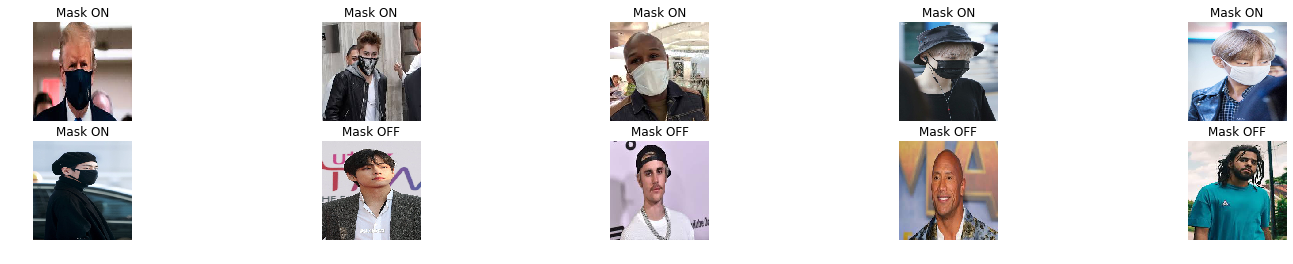

In [23]:
img_urls = ["data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExMVFhUVFRcXFxcXGBgVGBcVFxgXFxgYFxcYHSggHRolHRcXITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGi0lHSUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAJ8BPgMBIgACEQEDEQH/xAAcAAAABwEBAAAAAAAAAAAAAAABAgMEBQYHAAj/xABFEAABAgMFBAcECAQEBwEAAAABAAIDBBEFEiExUQYTQWEHFHGBkaHwIlKxwRYjMkJiktHhFTNTohdjcoI0Q3SywtLxJP/EABoBAAMBAQEBAAAAAAAAAAAAAAABAgMEBQb/xAAnEQACAgICAwABAwUAAAAAAAAAAQIRAxIhMQRBUSITFLEyM0Jhof/aAAwDAQACEQMRAD8Ar15OZcJgxycwYq5joH9Auom2/QGMgBd1EmQElvkUxEwFSipN0RAYiAFClWMCa7xHERAyzbKtaIzXHIFa7KxWkChWDSU+WmoV1k7dc2HeLhhwqrhJIzyRZpZiDUKKtbaGDAwJvP4Nb8zkFnE1thEcaB1OzBR/Wy7Eux1OKJZa6COJvss1p7VTUStxwhN0bQupzcR8KKBuF3tPc5x5m9nqSUlDmATiUvD9VXO5t+zqjBL0Mo0i0jHGunzTGJIYEU7xgpsjGtMEWNBGinZl6JlZiSjhx4+qpxLMoQa0PL16opR8uK1Td8uNT34I2DSiYs225iHS7GfTRzrw81Z7N2ziYB4a/wDtP6eSoEOEB95LwmY1BGHd8Kq1kkvZMsUX6NbldoIT8w5vaKjxCkmTDTk4FZfZ0xUUvGo0NQO7NPodtmG6hdUYLeOS+zmnhro0TejVdvRqqTNWqbt5rsM+xVia2xitNCafMeKtyRlpI13ejVBvm6rHTtrF95EdtpG95G6DRmy79uqDft1WNO2xi6lA3bCL7xRug0ZsvWW6rutN1WKR9r4pycUhD2qj1xeUt0GjNy603VB1puqxb6WxdXIDtXF94o3QaM2rrbdUHXG6rE/pVF1d4ov0oi+8fFG6DRm29dZqg68zVYkdpYvvHxKIdo4up8UboNGbh19mqD+IM1Cw87RRfePig+kEX3j4lG6DRlfCUDkQN9dqGiwNw99CHoAFwCYA3uCGqAs9euCG6gdHAoKobqG6kOgKrnIaLi1Azg5Pt59XStAcT8Eya2mOdMccEnEigmrnV9ZJgA+ubTgMkpLTDgUoIgu0zySgbieWChlxRLQHhzRQUIKUgRsSElIMw0ojxIdDVZM3UR413opSG/VIyyWDkrK1DYaVRHwXe6jCGCloEsdUrKoZNhD7w8yELYVMQPmpgwxTEA9w+KQfAZTAkd4+ACpMmiPecMAD30TSMceXrJO3QSON7hp3JxLyV51eOlVrExmqI/rLgwg1oe/T9lCz2dO/vKt0/ZtGG9hUHme1U6ed7ZryGvD4rQ55CC4Iu8GqI+NTikSKEoC5N9+EcPB4/JABijNCBpRwEwAC5DdQhqACkICEcBAB65IAKhCPdQUQAWi6iG6huoAAMQhqcNhIwgqS6G1xCGJ0ISFsJAUNwxdcTrdLhDQOhrcQhmSc7tHbA9fogqhmGrjDVysjYqLGbecQ0HKoqfkpMdHDv6rfy/uq0ZDlFezN5wXYTj2fFR0hK3vacc8A3ie3ktB2w2EiQpSJEEQG6WVFKUaXtBI7Aa9yqlkQmhw04A8APXmk012EXfQ4ZYzzT13KYgWcBmKlSsMNLcM0hGes5nZiihtuqZIS0FGc+qFsFYs6FFCVyiBz/Xr1ilzCTaI1S2NRQ4liCcwnZp6Ki4Tqevkn0PFKx6CkSJXIJBruKXc0I7Wi7klY9UJxId9hpmE7sJ1WB9ccQe0HXsISEvEDTVBPxhCguLcLxr2E4YdtAtsT5ObyI8HWxNA+yTwJx40aTnl90+Cz21H+1StSKg9q0LZqzevupEcQ1rQ6opjWradtT5c08tDoqYR9XGcD+IAjyouvVvk82UkuDHXzB8UhEjuotImei2YGT4Z8QmcXo2mhwZ4n9Eav4TaM8EV1c0+l4xVrf0ezQP2GnsKXlOjybJoWtHaf0CNX8C0V6A9O4bPXr1grvJ9F76e1GA7G/upBnRqR/wA7+3909JD2RnW7Q3Fo46OP87+390P+HH+d/b+6NJD2Rm9xdcWkDo3H9Z35R+qD/DVv9Z35QjSQbIzi4uuLSW9G7f6rvAIT0ct/qu8AjRhujNri7drSf8OWf1XeAQno6Z/Ud4BGjFsilw4PJGMFA2ZC4zTVmbHblBu1xmggMyEhoHdobqL1gITMN9evVUFBmsT2yIIMZlcqglRhmglZWfukFNFG0yFLoongWb2btYGNoSn302bqunZP2cTxysd9JMx/+Z7GkXrhNCaC6SASPxZAci7LMZRYsE3gK96nNtrXEaI1wJDS0XqZGhd7RxxOQ7goGVnLh9lYzlbN8caXJcN4AMMVHzEY48EWXjk4ZYdqGLifXeuebO/GqCsJKU6zdzSbH8eA9Yo/W4ThQgHDVZNG1irJ5p4okeICM/P4JvHloWd66dKqIiTNDS9yAB7AlqVaJYPGNDxp4p9CmAAKY10UJEmA1pJPEfH9E8lbXgNGJFdMvGvDsS1ZWyJWGCaYUSvYQVGO2iguIDTf7Bh5qWl4zXtqAO5JxZOyY0m3UbUJpascdVqfep46J5Mj2SBzUBPxSZN7RweP1KvH2Y5nwK7IbQR4EeCyCGPMSIyGWu4siPaDiMiMxXLHDOu7krzVYt4xGvaCC0glxFaUOeHHTitIgbdPYC2KKvDiPZypQEEF2OPNd+OSrk8nJBt2jS3IhAWet29B4FCduxoVptH6Z6svxaELQFnztvBoUX6d8vNG8foas0gLqrN3bdnTzRTt2dPNG0foas0qq6qzI7dnQ+KD6dHTzS3j9DVmnVQXlmJ26dp5ov05d6KN4/Q1ZqF5BfCy87cO9FEO27vRRvH6GrNTvBBfCys7bP8ARRPpq9G8R6soHWyhM4Uk6GCcMuFV27XMdIr1xCJtI7lCIKAFROIxm0jukO5SGc6aKFkyfVUAgoTBQMWbOlcZw+vXYkd0h3SAJOzo0N9RFwAbWvGuVPNIRpmEGXoTi4AjmQCaVrnRIwJe9eafvNI+Y+Ce2HIs3QJoM6k6A1p61RZtCOyJmz2gi9Woph25o8R2frxUNITLYTiL1Yb3ENNai9iS2uo+C5m0cq8lrY7AeZLB3OcKKXFvo1Uku2HtW1GQmG875+CpU/tC3gx2PEq3wpiTv33RpdzuF6JDIHPEgVSNp29JjAvY4/gq/uq1pHmnCL+GeSaf+SRTv4lEdTFwBxAqQpfZqC+NGDTXPjzQTdtSjsavH+mHePi5zU5ldr5aEawpeK46ueyGPANf8Vo8cn0jKOWEX+Ui821s0DLOofaGA7VkRe+tKGtSKUqc6K8Rek6I9hYJZjQdXudTnkFXJvaQuff3EMGtTQuFe0Y4pw8fJHtDy+Xhn1L/AIxlDgTgeBDZEIORDCfPJXexo89Ac0Robt2cCcCQedMQK6ppZG2MplFa6AdReezxZiPyq2yFtyjwA2aljXWK1uHZEIPks8kZdOJpilj7Ux1GaKE648+zkq7MkCE4au8larQLWsLi+G1vvOexrPzE0VBtS2JcfVsmYcR5IADA9zcTj7ZaG65EqMcJfC82SNVY7sqKGm6G1NK8Ka1PcjW8y4QPvON455ZeH7oklUC8AXUpeOWlSeSSjtL3FzsScTr6/RaHJJDDelG3xTjccl24QZjcRSg3pTjcLtwgBvvSu3pTncLtwgBtvCgEQpyIC7coAbbwrr5TncLtygBtfKDeOTrcoHQUCG28ciXynhgpN8FAxQQEO5/ZSG6RXMwQWMtwu3CkYMGqfQ7PrwToaIEQUIgclZxZTePkjizGego2R2LwcrV0Vbq6Hq6tP8NahFnMRsh/scvwqwlygMDwVt/hzEBs9iNkH7DKVIYFLTDKQTSuJJ8VZDZDdE1nJItpQVrhTWuH79yfasSxvHLWREWbYrTImE8kOe4vr7jvuOHZQHnU6rLI0Esc5rhi1zmnSrTQ0W1vh3PZ4AAUzypT1yWT7Qj62J/1Ef4tPzW/jvlo5POikkyIKFqFcuo80OKI7XBIrgVVk0P2EU7kLxgmrYvslvGmCWdFwFc1aZk4sTcQivgCmSEri7BLsrn0ImCFMbJWUY8R54QwO8uNAPAHwUUQr70QtBdM1H3YVORrEWGbiLo6vGW2RJlkgSpYws1pXsHBE6op+LAx+evrLuROrLjSO3JJNkJ1TggMopzqq4y3JVqZ2QXVV3VVOdWQdW5I1CyE6ryXdUU31ZAZVFCshOq8kHVVN9VXCVRQEH1Vd1RTZlUBlkUBCdVQdWU2Zdd1b12pUBB9WSTpdT7pdJPlsckUA2dDTWZapINTScYgsGz21VjlYWSr8jGa3M0U/LT8PD2gqXQ4P8kLRIeKEQgknTbSc06lXg8Vzrs+jlslY0jQ0mGp7MsSTYSTXJUZ8BWMR90Eq1iUaxNIhzDQYQokpqWBaRkeB58E9htwQPYumEfxPE8vI/1ChzU1u/ZiscHXgK0Jb7RArUYUxGKzTaVlI0XHExohpoPZpz4rdbWkd9CiQa03jHNroXAgHuND3LB7fjl8V7nYOve22mLYlxrXj8zCtMMdWzk8nLvFWRdEC4lcug4QUC5cgAj0aG5FeuYVN8lehYFGCTBTuRhB7wDlmewK7IaEXQjdLqYK89EYeXzDWAUIhXnH7o+syHE5qtTUBwuvIG7iVpnpUVwpiMaA4VFaK89Cksd3MxNXw2D/AGh5P/eFnkpxNcDcZ2X5sDyRtynLiBmaJlFtWEDStVz0dLdim5QblLwozSK1CWhsDhgQqoQy3SAwVIGVdoiGGlQDHcLtyntxBu0qHYz3KLuU+3aAsSoBlukUwU+uILidAMTBQbpPt2g3aQxjuU3iQVKOhpF7EAQzqAVKqu0FutYDin21dqCEw48Fk07NuiOLnHPySUbFOdEtH2kfXBJfSOPqPNQqMGlaaox3ZYZfaSYGN5WOxtqYxpUqjwWmikrNj3eCzcUdMc+R8OTNcsu3hEprxCsEJwcKhYrCtYsdeaaH4q7bLbT73A4OGfNYuLT/ANHteP5McyUOp/yXsMSjWoIJqAUoFQNsUhtwQOajwxgmVuWvAlYe8jxAxvAZucdGNzJXTBcHkeV/cZF7XWuJSVix8LzRRgPGI7BuHLM8gVg9ox7wDy0l0aG17nHi8Pc1zxreu17SVN9IO1Tp1zaAshMJuMrjoXOp94+Qw1JsE3suyYsiUmGANish3C7g5pe67e7HYV/ForS1ONvfhGaLryPNQHQ3FjwWuGYPrEc0jVXZlQcFciFC0osKBY0HNHuLgxC5ydE2FJTuTi0bE1LaBMC5Ly0UA48UrG0WnaiIxsvAY3BwDr4zAINBdPEYkg8QeWFp6M7SZBs91PtmPEJ/LDA+CzJku6Jf3bXOaxpe8gE0YKVcTpUjxCltnbSfTcN+8fY5E5jv9ZqXHijSMvys0KatVzz7Tu4YpSXBdwomtmWeIYvP9p5z4qWg5rGz0I4/pIWbDc7Aqcl7HcMQSFHWY6hCvEhEaWjJXHkWVakEyFEbiDUBNo9rQwaPq13NW6JLjgoa1bJhxW0c0dqZiql0R0KM132TVHuqJMkZdwAxHBTEuahS4ifAW4guJxdQXVIhuWILicXEFxAxvdQXU4LEFxADe4knsT24kojEmgMJ28mSX3eaq0jKGI66FYduf53il9jZIXrxRdIitpUBC2ZoKlKmxW6UVwnW4UHYoebitYKucG9pA8FjbZ2KEUiLh2OMFMSWyzX0Chom0kBhzLyPdHzKMzpCLP5cGvNzvkB81ShMTniXbLWdgAW1UH/AYknHa8Vuk0Kip3pNn3ijXshD8DBXxdUqsTtqx4prFivedXOJ+KtYm+yI+TDHJSiuUb3A2qk4LKRZiE0gZXrzvytqVD2l0rSTP5TIsY9gY3xca+SxCq5aLGkPJ585O0ki/wBrdK85Eq2CGQGn3Rff+d3yAVNmJ2JFeYkV7ojzm57i4+JTNHatY8HDOcpu2xSafWi2zolmGxrN3LsQx0SG4cnG/gf9/ksQiFaT0KT9Hx4JODg2IBzabp8iPBN9krgd7S2C1rzBjNvUxY/IubwIPDQjXuVCtbZ9zCTCJe3Q/aH6r0PatlQ5mHceKEYscM2nlyPEcfCmZ23ZMSA+5EH+lw+y8atPflmFzNSg+Ojti4Zlz2ZTyXVV3nrHhxQaijveGBVenNnojfskOHgfPDzVxyJmM8Eo9ckeyJQJJ76p4yxo5yhnyHnVOZbZ2M40ddaO0OPcGq3NfTNYpfCIqn9n2TEi4gUb7xwB7NVZ5DZ2DDxd7bhxOXc3/wCqxWLZT5iKIUMUGF51MGtriT8hxKyeTmkbLDSuRZej3ZWGLOjsu/8AEh8Mu4uaGlta6BznflWHQw6G+mTmO8HNPyIXrCUlWwobYbBRrGhoHIa6niTzXmvbyR3NoTLaYGM5w7H0f/5FbxOaTt2iUldri0gRgXNcAQ8ZjUEcce/tVikbbhPFWPa7lWh8Csve+oA0Jp3pJuHJKWJPo2h5U498m2ylpgKZkrbcO5YZKW3Hh/ZeSNHYjzU9Z+3Lmn62EHD8JofA4KP0pLo6V5eOX9Rvlm2+HYOT18yHHBZVYe2EjEoDHEJ2kUFo/OKt8wr3ITAc2rHNe33mODx4tKdP2NKDdxHFqNDh2KPsd5vuDsuCdzJNCmspFGNM00RlVEoQgolJOFVoJS5gKXEwUhpdQXU73CDcpaseyGl1ddTvdIDCRqw2Gt1IxGp8YSTfCRqw2PNFtTO/LYlMxj2p/ZNqMgNq84+6M8/JVkRqCjcBrxSblbxp8GayNOyxWrtfFfhDAYNRi495y7lXYsVzjVxJOpqT4lBRCGqlBLomU3LthCEBCUurinQrE0COUVTQwEKBCgAQjAooQpoRzlbOjGPcnWHU3T2OFPjRVMqe2KfdmAdC0+DkAejIBQ2hIsjMLHtqD5HUHgV0Ieu1OWhDGmZpbOyz4JL2VczHGmI7VVIv2vFaftbtXDlXCC1t+O9tWtNQ1rfee7TkMTyzWNW3MTF90SrfaNaBrWtHIAcELwpyjvFcGq8+EZKE3ySUV1TQHPPXxTiDXhmqcJ2YcQb9KZUoB4K/dHcWFGeIEau9xLT913EjD7Jw7MFH7XJVmr8uF0OrOsN8V2NaV8Fptg2a2AwNaKa8zz1R5OQawUAopKHDTUVHo555HMNXBYV0wytJl8Sn3oYPew/+oW8XFk/THJfVxH4fbafCg+apdkIyByKEaGMEBC1MzguQhcgAKJeUmYkJ1+E97HascWHxCSQgp0K6LbZvSNPQ8HxGxm6RAK05PbQ+NVa9n9u4EU+39U8nI4t7nfqsoCGiNUX+pL6er7IiB0JrhQgioIxHcna80bK7azUkQIT70OuMN1XMPdwPMUWw7LdJEtN0Y4OhRThdILmk/hc0fEBZuD9DjNMupQGiTjRboqVR9rNsmwAc+4KCy4zM8xmZCrdp7Xwof3gFjdrbexop9n2Qdc1WZu0XvqXOJUbFUb3B27hE/aB71Lyu00J4zC8whzuBPincC1Y8P7Lz8UbAj//Z",
           "https://i.pinimg.com/236x/ef/3c/9a/ef3c9a05a6d29d959c9c7449d2e1a243--skull-mask-a-skull.jpg",
           "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS0i_65_RVHEKrGfTJxNJmzvQbwGzDEi6VF7A&usqp=CAU",
           "https://i.pinimg.com/564x/d1/71/64/d17164e4786c6e377df3f79f6edaa890.jpg",
           "https://i.pinimg.com/originals/8e/b2/cc/8eb2ccf93e83110e1cf02f8fb0a25fa5.jpg",
           "https://em.wattpad.com/0de1dd8df23089fcef08aeee1bad45f5369e7905/68747470733a2f2f73332e616d617a6f6e6177732e636f6d2f776174747061642d6d656469612d736572766963652f53746f7279496d6167652f6a38553069394e7576707a435a773d3d2d3733313532363535332e313539656130353261356130623466393239343439333835343037352e6a7067",
           "https://i.pinimg.com/originals/47/96/87/479687be5910f37ac76914eb3f4b5475.jpg",
           "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISDxUQEBAVFhUVFRAQFhYVFRUVFhUVFRUWFhUVFRUYHSggGBolGxUVITEhJSorLi4uFx8zODMtNygtLisBCgoKDg0OFxAQGCsfHR0tLS0tLS0tLS0tLS0tLSstKy0tLS0tLS0rLS0tKy0tLS0tLS0tLS0tKy0tLS0tLSstN//AABEIAMIBAwMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAAAQIFAwQGBwj/xABDEAABAwIDBQUFBQUHBAMAAAABAAIRAwQSITEFBkFR8BNhcYGRByIyobEUQlJywTNiktHhFiMkgrLC8UNzg7MVJVP/xAAZAQEBAQEBAQAAAAAAAAAAAAAAAQIDBAX/xAAjEQEBAAICAgICAwEAAAAAAAAAAQIRAyESMUFRBCIUQoET/9oADAMBAAIRAxEAPwD1SVzlxuRYPqOqvtw5zyXOJLsye6V0EpEr0ujFZWrKNNtKk0NY0Q1o0A7lOtQY+MbGujTEAY8JTlEoqVKk1vwtA8AB9F4/7VN5XVbk2LA0MYWhziAXFxjjwAlewArxH2q7DfSvXXIaTTqw7ENA4CCDy0Czn6Zyd3Y+zSwNBgexznYQS8PIJJGuWS4P2h7lssMFSjULqbyWw7VpideIU9i+066oURScxlTCMLXOJBgaTGqpN4t5LnaNRoqZxkymwGAT3cSsWy+k6elexu+c+yfTcZ7OoQ3uBEwu/XJ+zbYD7SziqIqVD2jhyyyHoutAXSemoSYC0dubYo2dB1xcPwsb5uceDWD7zivENu+0y/rVnOoVnUKUwymwMJAHF7y0kuPGDH1S5SFunv4ajCvlittq5eS51zXcSZk1ah+pyUae1a7RDbiqBMwKtQCecA696x5p5PqjCokL5g/tDdl/aG8uMWWfb1Zy/wAyvtn+07adGMVZtZo4VabSY/MzCfMyr5nk9+IUCuF3T9qVtdObSuW/Z6riACTipOJ0AflhPc71K71wW5drtiKiSpOCgUUkigpIBCEKgSQhAIQhAISQgaCkhAkIQiNyUkIUUISQgkCoXFuyo0sqNDmnUESE5TBQc3V3A2c52I2wHgSB6BWmyt3LS3zoW7GnnEn1KsQVMKaTSYXMb876UtnUwIFSu8TTpTGX46h+6z5nhxItN5NsNs7OrdOE9m2Q2YxPJwsb5uIC+atp7Qq3Nd9xXfiqVDiceHIADg0CAByCzllpLWxt/btxe1u2uamJ2jQMmMH4WN+6PmeJK0GUy4gNBJOgAknwAWWztnVHhjBJ+g5ldZsjYr2/s9eJ08pGcLhlnMfa44XJT2u6l08YuzwA6YyG/LX5KxG4FyRIfT7viAPnC6G62W9tPFXuWURwJcBP8Wqow/s3/wB3fl0caeInwxHILEzt9N3i8fag2lsGtQ/aMy/EMx/TzVWQumuyHYiXvcTxdDTHeRMrn6tPC4tOcR9NV0x38uWWvhrQvSvZ/wC0d9FzbW+eXUTDGVXfFR4APP3qfecx3jTzksRC1LpI+q3LG5c37MLx1XZNBz3SW9pRnjhp1HNYD4NDQulcF3lbYykmUkUJJpIBCElQ0kIQCEkIBNJCIaEk0G0kmkooSTSQCEIQSCm1QCm1B5t7dL0ttre3B/aVX1XDmKTYE901AfJeNOK9N9vDj9ptRwFGqR4l4n6BeYu0XHL2xXZbv1La3szUrO9+pBDQJe4AnIDgMtTkta63rrO92iBRZwiC/wA3HTyHmudoUycu8Ac55Lrti7nGrDq7ywfhGbvMnILhljjO8nXDzy/XFzVy8l2Nzy86Y3Eku5ZuzW/srY1zVM06FVw4ENcGn/Mcl6psTd21t/2dFpP43e8/+I6eS6enPJZ/6/TtPxb/AGryW33Bvngk0WtnM46jf9pKr9s7i39N4ih2kgGaRxAeMxmvcqb1Gswnr9VZy1r+Ng+cL7ZNxSzq29Vg5ljo9RktBfQ1+3IyvOt5N2KdV3aUxgcSZgZHI5uHlqrOX7c+T8bU3K6z2K3Ids59PF71Ou+RyD2sc0+BOL0K7twXhns7v6tltRlF2Ta7m29QcDJIpuB5h5Hk4r3V4Xrwu44RhcoqblArSkhCSAQhCoEkIlAISlKURJJJCKaEpQiN1CkkoqKFKEoQRQpKDnIJhTaVqmqmKyDg/bfsc1LSldtGdB5Y7/t1YE+Twz+IrxWZgASdB4r6T3rodvYXNAauo1Y/MGkt+YC8K3c2YezqXLxADS2nPF3Fw8Ij1XHkuu01urjdbYZYBWqamYH4dPqCuvtnAarRs3A0gRy+ip7+7rFxDPdaJzdl65LxXeVe/DWGPTvqN+xsAkLfttr0nGA8HzXid9QqEk1Lls64ZMwO7Uei2NmOqUH5zwmDPryKvhqJOa2609w+1DPPRctvLv1Tt3dnm53IRl4lbmzK7atIuLjJbovP9vbMeajnCnij3hiJgieHM8YyTHut8lsnTa/t4+pow+k+qsrLaTnscXNEgFwI00PzzXP2LK4YZoU2wWgNaCx5nUyCdO9dbb2x7OSI4EcsuK1dRzx3Z3VHbWja5ZWgdox7KrYMFr2OBDhzHuzC9R2Ltdtw10EY2HC9o4ciJ1B5ryTZtMtxNOKWl0RmYBI/QrT3S2zUo7apw44ajvs7wTMh+k94dhPkV6OOvHl1XuzlApOeo4l6A0k5SQCSCkqAlJCSBpIQgEISUQ0IQqMn2hSbcKi+0lTbdrG1XwqqYcqSneLZZeBXYsXvWnVqrE65lQJlAzUTDlCFJqgpd5biswYqXEHPwB4eq84vah7CTkCWNAHAZmflovWto08VOMM9x/ovLdt0zJokQRD/AOEmfkSvNy9ZR2wm8atthumi3wUr/ZTqjSGmOPf5LS3fqwwNOoXTWdXPNeW+3rxm5HKUN2BiBNAkiOcE8znmrfbFu6pUFSo1uKILgIkDQQMl1DHhVm3HADwzPjwVuV0s4pGLYLolqz1LUVCWk6ExnC0NmvgyTB1VoazG1mkPBmJhTF01NM9vsljc8MnmSSsd4zCDkruo7LJUu1nZZLVZ0872zcvotqvpjOpUFFsCTLsRyHP3SFdezjcSq2q2+vG4C2XUqR+LEfvvHCJyGvErp9ybUEvqlsySWkjT3nNkd/uldW4r28WPW3zeSfsg5QJUioFdWUmuWSVgU2lUTKimUkCQhCIEISQCaSEDSQhBREJQppLmILFXuCFnhV9+FBuW11JVxRMhcvZH3l0tmclqKzICEKiYXKbz7KHa9thEOETxa7T0P811IKVak17SxwkHIhY5MPPHTeGfjdvKbN2GuWjjnHJdDQeo7c2H2FXtgSWnC0cYyjXyHosTXxmvFnjZ1Xr48pZ0uaTzC0L4Oe0jiYI8jP6KVGuYVNtXbpecDMhoVz7dvKa7aP2Z76pc6u4RkA34R5cSt2nb0m1WVKjny0lrjiOcH7zdIWna16bXS12IggwAXZjubot+rdCqCewfJBGTImdZOq6QmFvbtrbaDKjfdcCfFVG17jLVcs22r5vt6b2xqCQIP7snNWRqvc0GoCHAZzz1Se2bl8PQdk27adBjWCBha7nm4SfmVsOKVFuFjW8mtHoAEFfRnUfNRKiUykgSbSkkCqMqSQKaAQhJECEkKgQhCAQiUlBTpJlJc1JaV83Jbq1bvRRGtaszC6Ky0VDaK/szkrFZykpFRWgBTCgmEGhvHRx2zxGYGIeIzC46g6QF6E5sgg8RC84qnASD90lvoY/ReX8ieq9HBfbbc33YC0xsilhh7Q5xJdJ5coWdlXJJtSDmfBeZ6pYlb0TT/Z0x4QIW5QrVn5FoDTrA+pW/ZPbHAqxpuaArK6eVUlQlg0jTRYLVhq12M/E4T+UZu+QKy7VuhPIQrjdCzHZduc3PkD91oMR5kfRdeHDyyefm5Ol+5ygXJuUCvoPCJRKihQSSKE0DapKIUkCSTKSIEIQqBCSFAITSVFOkmkuQS17kZLYUKgyUVWtcQVaWlyYWgWLbtGIN0XJWVlYlY+yUmMWhstKkFBimCqMjV59fUSa1URpUf5yZXd1rhrG4nuAHMmFwlCtiqOcfve/6krzfk3qR34PaqqhzPh0/Cf0WJ18eIV9d2oeJGRVO+1IMFq8uNejLFK32yGcY8VsjeNjjDDLuQzK1P/gHVNAQOuCutk7FZS1A78tfErpJE/b0067Hvb2tQQB8LeJ7zwXY7mP/AMG0HVrnt+c/qqHalMvEN4EQNMgVabm1mtFSli951QvaDMmWiQP4TkvRw2SvPyx0bljKm4rGV6nEJSkSlKCaYUAVIKDIFJQCmgRUSpqJREUIQqBCEKAQhCCnSUiolc1JRKkUMGagxMpZret6ULNb20rc7CAtSDEEkyoEqhygJU2FxhoklWNtsxwIxiJWcstJtxe0LgV3mmWnDLqcZNjP4pJ1nOO4KrtqRa51N0YmnCY0nmO7Q+a6XevYnZXJc1j3sfhqCk1jcBqaF73ZTGuZOpyJhVlwxstdioNqNAxsYcDi0wAcDoJgznAy8F5OXG3t14eTV19oU7Ykqzt7RgGYkqAOUqTXrlHt2TqcOyU3UARmo1DxRjK3EtaddgByVXWvm0a1Oo9wDGvh5MiAdCHSA0gwZP6q1rDOSqDazHdm92uH3tJ0wuzHHRblcc+5p6nsmiLi3bVOT3YgYiJBImORAnzWG4sXtPNaG410af8AdR/dENLC34GmfgAObCNC3OOHBddeNGvfC9UyeHenKOBGoSlX76YPBYHWTT91a8l8lQCpAqxOzRwlYK1g5uYz+qu18oxNUgsY71MFVTSKcpFAkk0KqEIQVEJCEIqoKRUyFEhcxBbFtTkrBCsLJqQWNtSyWSqFkoNySrBbFZW1WNjS4wFmrtzW5ZW0arGWWktbFhbBmY15q5pkPbHQWgxZGuIOXDrr+iwyhvBs3tqOGXAiD7rixxAzIDhn/wALhLS1ewe63s2auNZorOcTxOF0mdcTnE6ZL0qjWnx5Lkt59ndnU7VjA4POYLy0AgaRBH04rNiOepxihtRr/wAoIA7oJJyU3NK3Le7cyo3tGOeMsTS1rxByn3JcD+8fkuqOwbeq0Pp4mhwkQefMHTwXK8f09OHPNduJByUQuudukJyrerf6op7qAHOr6N/qpMMnS82H2499OQSrXYO75quD3tinIJn70cB3cyuttNh0af3cR5uz+WisIXTHD7cc+bfWLz42v2epUbTBGFxkMJacLZ96o2YcYwjGBOYldXa3faU8cRJGR8Aqrey3LXdq1+AEjFIxtxfvAe80QJxAiIk5CDh3cqkN7NzWN1IDHSOfIHOZ075zy6xwXqEkLSJddfJJxCaY669FRrVrcHgq+vRLT3K6AUK9EERCsqy6UgKklUZhcQVym0tt3bLtlBrKYY8uwvJnJuZkc1rbe3WJwqHb202G2cynVHaOpvLMJ1LdYWpsre+kaPvB2JtEVDIjFAzg8U2One4AEkwBmStDZ+2aFdxbSqBxbrCqqe2TdW9xTNM03imTEzLXDIrlqVU0m2lal7pfQqUzHFzRIn0Klpt6DXvcLi3ATEZjwQuO2ZZ3deiyubwgvGKABl3ITdTbqoUSF5Jc7/3rvhcxn5W/qVU3G8d3Uydc1D3Ax/pXLyNvaq1Zrfic0eJAWNu89nS+O5pj/MCfkvE2WVzWOVOq/wAQ4/Mqwttzr1wkUCPzEBN08nvWwduW900ut6oeG5GNR4grduasZDM8AvKvZJse5ZVfcEYKZDqUGZe5roJaOQh2fE6L1q3twO85Z/16grXn0u0LOz+87MnqArBtMKLW8+uvqpysMlCI61RKOuuuaqGCnchlWmadUS1wg8/mo9ddc0dddc00OH2pZi3dghoaXHB2dJ7S4ADLHTJAMakiFZ7tbddScKdT4CXRLi5zcsnGfeIPeJzCv7y0bUYWnyI1aeDh39cVwl5ZPp1BRqsqVIbjD3Bj2DMx7wiDlxEwQs6HqQqgifNLGOa47YG3Xtf2Nd9POBTw1CS4xmMLsxz1Oq6btXcz10VqI28SxveOJ9NfVaxqHieuvql4ddQPVNCr3scTRbheacPBDwJwkA5kRm2JnLQnTUUOwWAV8qTacnPszkT7w94QJ0kOg/fEjRXG9gJpNaCQS4wW/ECGnQccpyhUexGf3wdAbLgPcPuuEl8FuUHjOepEmM58q7KEQmoraGhJM9fX+SBypLE85KYKo5rfezeaVOvTJBpVGOeAfipn3XT4SD5FedseQWFxJ7K8ewk/hqAx/qC9rfRD2FjhIcC0jmCM157/AGPa11VlSo52KoyryzZGH5AJpY5ShDeyb+C4uKB/K/ER+ihTAqChRZm8NuaDgNYByn0Xdt3atu1NUslxIfmcsQ4xzW9Q2fRY7Eym0HMyAJz1V8WtOR3KpjG5mCoXmkGVHvmARkGha1vsO5NSlbupxTo1arxUnItcDAA813wAGgSJV8V05zZWyK1Ki2niHu448C4kfIhC6HEhNGnnf2HYtD4nU3Ec3F59Enb37Mo5UaM/lpAfMrmLXcC8d8QYwfvOk+jQVb23s0P/AFbkeDGfqSuXaf4lc+0kf9K2/icB8gsew96by9u6dtTwUw93vENktYBLiJOsCPEhWTdxLKmJqve78zw0fJdDuXsqzY99a2YyWjssQOL4oc4T4AJdnbsLKg1oDWiGgBoA5DQDv4+IKs2Drhnx8D8itGgcs/n/AD8Yz4GDxW213Pv4esjlwcPArMSs/X6f8ojrrrRRL4/rwjWfD5hOeuvT0Wohx111mlHXXWiWLrrrMJl3XXn8lUAR111wSnrrrRKeuutEEgeuutFo7X2a2uzDMOyIc0lp1BiQdD+oW5PXXWieLrrx+ag8/uqFRlR9MUiw08OGqcNQOmDI45ZZZcc+Cutj7ccxwoVg9wyHaYIAkSJg6ZcpV5tCwpV2GnVYHA5Zgfr3x6rjN4dlOo4nPDXUAMUMovkRkc2kx3AAajMqelegNIIkaHTr0TaOXXWS852Rt6rRGJsGjgaWUxTOIyJyJfkYPdmc11NtvXRLix4cx4YKjmxiwg6Yi2QDrrrhMK7GHe2oDhpzGXxAw5pdk0jlkPnylVW789sxpZgcSapLfheM57wQ85z+PXnj2xWdXe9rBJzxiQC6m5hIa2c5jDHe0jQlWm6TA4GsBk4DBMktxNaXASMhMGJ4lSeyukCRQXDrrwUZ6681tDhAPXXqo4kg5Bk4LFi4eSyNcsbnwfHJUbdu7JU+3GxUDuYjzH/KszVgeGar9vGabXcjHyI/RJ7We1c2opYlpCopCstujZJUC5YzVUHVURkxIWt2qaDWecivP97r+s2Q2tUGuj3D6FCFypXAVq73H33ud+Yk/Vey+yAf/WGP/wB63yDY+iELmzPb0K3GY8WfN7h9MllonT/x/wDsc36ADwQhWFZ26fw/J5A+SxNOQ8B/vH6D0QhaiVl5dcHFDdev3UIVQm6en0CJy8v0QhBGcvX/AHfyCm7Q/wCb6OSQgZ/n9HJ1hkRw/o5CEHlF/UJvw0uMdnVdEmJFRoBjnHFb1ZoNF7SJB7KRwMipMjyHohCwrU2W4/aXGcy7CTxIFCiQCeIl7/4jzXd7nj/A0P8AtMPyKSFrFFuOvVYnHryahCok09eZUXaeiEKiVNYrrUeKEKz2MlQ+6fJaW2D/AIceLfoE0J8rHPpEpoWmzBUHFCFRgJTQhB//2Q==",
           "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxASEhUSEhAVFRUVEBAQEBUQEA8PDxUVFhUWFhUVFhUYHSggGBolGxUVITEhJSkrLi4uFx8zODMsNygtLisBCgoKDg0OGhAQGi0fICUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIALgBEQMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAEAAIDBQYBB//EAD0QAAEDAgMFBgQEBAUFAAAAAAEAAhEDBBIhMQUiQVFhBhMycYGRFFKhsSNCwdEVgpLwM1NisuEHQ3LS8f/EABoBAAIDAQEAAAAAAAAAAAAAAAIDAQQFAAb/xAArEQACAgIBAwQBAwUBAAAAAAAAAQIRAyESBDFBEyIyUTMFFCNCYXGBoTT/2gAMAwEAAhEDEQA/AL9qeGqNhUhcvNmpQ0hPYUgQmjVESTBSAKEuhdbUXUdQ8uXRlmo5XLl8NRxV6IlpFXtKvmmbJdJQV5UkonZBzWi4VjKydzL7EuhyY1OCoUXSSVwKNzlzGpolImLkBfHJE4kHdFOwr3IVlVRK8HNdxJwYuFq9DHsYz7iLkxpkpPUljSkoM01CDYWOLlKi4sqUBTlyYDAXNV51vk22bOOFIkDk4OUcJwKig6JghNoVIaiWuVLtevwRYYcpCJugGjVh89Vo6RlqyYOa0ey6stVnqo6TFYpbCHBNUjguBqp2WyMrkKUsUbzCk6zjXwUzadHE2UnOU9LeEI8cnCSkLzQ5RM33ZSV18Ektb95EzvRBqNRSkqvtKkhGgrDnGmai3smaV0KDEk1xUKIXEIc5NCjenUpRJaOJGHNB39bJGPEDzVHe1syn4YWyvlkBVnyUdsk5qnuqsBWPZ10lX8i/jZVg/eaIOUgTQ1PAWXZpIaU1zgBJMAZkkwAnXNVlNhe8w1okkrzzbW2qly6BLaYO60HXq7mfsmQjy34OvdIu9r9rWNltBuN2mIyKY8hqVnK19dVc31XRyacI9gla2nRGi1KJzr4jVhv5bKt1J/zn3KkoX9emcqjvUlw9jkj3W6ErUEcM8l5Bn0sH4Laz26HwKgwn5h4fXktTs9uU89F5sWEK22Jt59HdO9T+X8w6tP6aeSfkyyywoqft1jlfg3T35qWmUFaXTKjQ9jgQeP6HkUW1yqNVoteCYuTSVGSn0Rmgqjux2u/C0nosjUvcTz5q97QXOFkDislQ1nmr/R4bi5Gb1GWnRbSrLZFeDCqGHJEWtSHAo8kbi0DF0zUPemF6Y0y1RvWbx2aMHaJzVUb3yoQ4pSp40GkdlS0HwVCSuYlLRzVotMQXVX96updMT6RmbCvorYVFmtnVdPYq/oPCt9Vi4yF9Lk5RCMSkYosQUjHKpRbOvKnt1AXLveQFNXoCWkc2jcZZeSz9d8lF31aSqys+Ar+DHSM/LIAv3kmFf9mmwFQOEmVodgK51EeOEr4XeU0YTmlRMcm3ly2mx1Q6Ma5x6wJhYdGwZHtrtIvqfDtO6yC/q8iQPQH3Kq7K1Cgty55L3Zuc5znHqTJVxaMhPlpcRmKPkIoW2WiI+HHJE0GnUlEPdA4eySWLKmpa+fsFX3NvHVaN9VxEYR6T+6DuLcOGn6IkiORnXM6IKpT+iu7m3jRVbm/dMhYuf0P2VtF9B+IeE+NvAj9+q9CtqzXNDmmQ4Ag9CvNKjOK0/Y+5lj6ZPhdib5O4e4PunTXKNlVe2VGoc8KSm6BKCGZhP2hWwMPkkONtJE5ZUii2xWxvhVr2wiGZklcqsW9ixqEEjEyy5Sskt3SFIhqEhFFVskaY+DtF7sutLY9EQ8Ko2bVgwrSu7QrMyxqRodPLwLJMcmYkg9DRaOpErjimlymjmdxJKPEku4HWZCiYKuLasqmoxFW1Ra/V4uSsw+my8WXLXKZtRAMepRUWQ4G1GaaCu8TK9WB9FHTKhvXwEUY7EZpgVd8lBVzKme5RUmyVqYIWzMyy0MLMlf7AbkqasrzYPhU9d+IHpPmWo1VH2zuMNvhGtR7Weg3j9grhzs1mu2D5NEQTnUdA4ndA+5WPjXuRtS+IFs+hkABwV3Z2nRZ4CuPC6HcgJARVOteshxMicw4EecGB7LnG/IcZ8dUaplpAy9MkvgnOOf8AfVC09o46bTocXDzhWD65/pHqlUrG8nVjH2BHhHn/AMIG6pYdQmXO1LoEYCGiBM5mUPUq3VRu++BGopu+/D0TeK+wObvsDXDgQRKqa1ODI/40Vm+k6Bi3hwc2DHsELUbwPp9kcdEy2VtTNF9nq+C4A4PaWn2kfUIeozNRsq4Hsf8AK8E+QMo4vdCcn2eh2Qkyu7TsnVMgUNQrYUU2/QVJS5IROLkC0thGNV13Z93NGt2nCf8AxdWV1eXyVX0iKw7AfzS/gr+asv4v0Xf4n0QTz5GFHBRVt2c9plGuBwpz78FRvuxCTJzl3Q6EOJAXpoco3OSlHRZsIDkxz1HK4Vyic2SY0lDKSniDyKVzMlGwQiCEzu1vSjaPPp7J6T1K0oVmRRLDxWNmhxka3T5LQS10Kvu6klTVqsBAOcoxQ3YGWdiIkoynRyUNtT4o2Fq4o8YmfOVsr7hquthjdVXcU1bbGG6q/X/iHdJ+QIrPzWd2u8Pqgf5bYMji6Dl6Qr2u7eVDckOqvMZDC32H7krKeom0t0UFS9uWhz6bQMLx+XG9wJMnyGS1ex7urVtu9qEB0kCm5uF7mgCXQCeMgAjOJTbe1ZrI55if1R1a4wt3TwyOg9AlvLGqoJYZXdlXQeDWESGkBxBkZ+XBW1e6lxAPA6KmshiqF3AZTzRlR0uBS33Hxjo7dmoSA0QMBOJwOGcMgZazpwCqNkbTvahwupBgDHOJfTexpIMBrXTJny4LU29LE3LPpP2UucRy5y0+4/ZHCaS2hWTG29Mz9lcPcTipuYQd4Ogg9QRkfoU/adEZERlrEQrSszll1yKCuGbuf009uC5S2Hx0Z+uOKDrjUDPIHojawzIPAlQ2dMPcSfC0e7id0J6+xL3ov7LazCKbXSHFrQcobigSPdHlyrHbPAfmcRFPEOQInTkMlaEIoSsHLDjRHiXQ5IhIJtFayRqdKa1IoWMXYRK4uFIOXHHZXZTV0lQShBy6XKKUiVNHXodiSUaSmgbBcKf3afhUoYttmGBvamB8IirTQ1UKp1GO1Y/DOnRFVfKYwSVxF2dFKwwth5JaCqFOApC1PwpQrxWB6jVYbNG6gqqNsPCqXX/jLPS/MHuHbxWcoVZc6eL3x/UVoax3isw4YKz2/wCrd/nOIfePRZsl7TXg6kaOzpyOqg2pWgFgmYzjhy905t0WDC0S6M+Qnmqq47zEc/FBJgO0GkSOSrqKbLcnovtmWThTybOWcCUyvQeTk0obZ21nhsGQfCYnCf75IouuHR+KKbTnDWd48+ZJACn0/s5TQRsi4wuLXjPgRoVblzTwlZ+1DxULnkaRwE+kmEcaj27zRi6TBUdmcya5ZGYVPdO5I24uMYLmTIyc06g8iqe7q+Fw45HzC7yTeimvH7x8la7AsJaCXEQ9pEZEuIkfUR6lU1yMz5rQbOZNFnCH4j1gRA90+b9pWgvfssb+iGOBH5mub1nKfLIlLEq8Pc55BJyc7XPirBtEpmJJLYrqcnKWjiRTu4K78O5HaK96GgruJO+GcufDOXWglIbK4Cn/AA7k0UHKLQXIS4XKQ0XKN1Fyi0G2MJXMSRCaQjAY6UkxJcRbJAETTYmMYimNWxJmOkDvpIWtQlWpYozSUdySjbb56KzoUYCI+HClDEMYqPYmTsEc1LCiTTTXNRgANYIyz8CgrBTW53FS678ZZ6X5AFd+8VTX8d+082MPq15/Rysbh28VW3436ZOkvYf5hI/2qk4+w0IZPckG0ycBdzlxVfSvAXSSOUIzZdQFjmu/K5zTy1VTXsGU6weGYmzOEzhSIRV0y1JyfYv7CuxpO8M+Ex90Wys2ILxrlnJ+idY3Vi+MdpEST3dQmSTxEhW1Grs4AYLRzyDJlgPA6lxg6pnBfZz5L+hlC+syZxj3190+jtDm4D1U97tS3fussGSA4bwYAJPQdEHabObiNVzGhx+VsNA5AIJRigrn5Vf7Cq0kteNS5rHQcnNdln65qruaYDX9KuXQQD+6sq9ZrCCRk2anEDIbv1P0VfWP4InxPJef5jKT2DTsprvU+asNm7cptpmi8RG8x2oziQeWirLt2ajFOWk9FZUU4qyu5NSdFpabSGOZ4rQ29+DxC88oXjQVeWV+0p/ooz3lb2bAXreYUjb9vRZz4gJ/fhQ+nTI9VmjF+zol8ezos2a4S78If2qJ9ZmjN8zom/Gs6LOGsFzvQu/bI71maP41nRKrXaRks8SiKFZQ8CW0EsrYRV1UZcpKgkIeVMR3IfK4mJIiLLQKVhUTQp2LWZkkoXCFxpUkqAhjQpA1NBT5XM4jeFA8IgqN4UoFgFYKWid1NrhNZ4VU634FjpvkVVwd4oHaYJpmNRDx/KZ+0oyu04jkoK4MaKukqHXsrrG5/FPJ7Z9R/YVpRAdrwyWYe/u6g5TI8uIWht62YI/MB7qpkjRfwz5B1O3IO6ftKMt3VdJ9oTLTl0RtCm504TkNTxQKTLLv7ITSjMgJCoTpoPuo6gOYn9EPdVw0ZHQeiHbObpEG0KwqVG0+AMu8hoPdDX9zJ6DLLRCOuYJcTmZQVWq45DUo+IlZKGwXvy0CNq08LY6GUbY2IYwHjzUV/ofJdzt0g1CotsY7s1hdBHAEciCJBHSCj7LYIBWgtbcVrK3rMdkwPpPBGeEOLcurH+4BQuy7oOe6k6BUZqNA4fM39uC3ISUlZgSVOh7NithcdsUK5YE4oqIM+7YwUbtkLQOCYWqdEGbfspQmwIWkfTQtamuaRCso3CMl1hU10yFA0qlONMsRdoOoPyUNTIpUXJVgq9UywnobiSTFxFRNl4FKFG0KVq1DNOhOc5chODVJxGCiGqMMU7WqGciNwUbgp3BROCglgVwE62A4p9diq7t7m6JHU43khSG4ZKMtluLamV2pYMIWdG0HjimXO3u7bL3ADrx6Dmst9Nk+y360Ct7XbNaHU8Jz3zA1gRmq7Zd9/wBt5hw04T1CGpbTfXruqOBiI6NHAfX6qe+sw7ejrlqOqlx41GWx2N8lyiaayvgBr1VgNqRphzEZidOi88D6jPzGPMypG1ydSfcqFj+mN9d9mjX3O1mCd6SeslUl3fl56IKm0Hj+6Jo2+ajSOuUjlKlObszwCNtLef3So0XOMAfuri1t4HklykNhAc0buaq7wZEK5c3ogXWpe9rW5l7gwDqTA+6XHuPl2NnsumKOzKLY8een+bULzPpKwm2SRWxsdDwcQI8Q1j7H6r0jtIG020aQMNbkOAhjMDfq4LyftE11Oq4tLmh8kmYZI1iAIOp9FuY3wiecye6TNjsPtCyse7fDawE4dA8fMz9RwV2vKLS3NcvxatIcxzCRB5SOMhbPY+3nMYG3EmB/iBs7ukvGpIyzA46cU5S1YP8AY0ZCYlbXFOo3FTe17To5jg4e4UjmorOIiENWYiHFNK4gqLuiquIV/cMVPdMgykZY2rGQeyNhRLW4kHiRVtdBuqpzTrRZi15HfCOXEZ/EWJJPKf0MuIcGp0LgSJW20Zg8BdTAnAqKOHtUoKiXQoCJISwrgXQVBI19KUNWsgVPc3dOm3FUcGgcT+nNYXbXbKrXd8PYscHE4TUcAH5kNAYJMajeOnJDKaj3JSssdv3FC2aS6XuESxkFwnTF8s/3oV5vd3L6zy98SZDGgyGDkP34qz21Ugig0QKcB+9jLqxH4j3O/MS6c1S1aYJGeYmJlK53G2TVOkbPsPsWk9uGprVrNpN5gyQ0jrOfojWWbmksMSC5ruUjI/UKu2HUFEUqocThuKBGZE7+c+RHHXehbHtFZGlcvIG5VPf0zwh+bh6On3Cz+plyVpdtGh0SqXFvvsy9xsoHp0CEs7FpyI0K04pg8FVXdAsfi4H7qtGb7F2eNdztPZTImJPCDHuUW22by6FcoVgRBKIYZ8v70QuTDjFeDllQ3tOMjmj+7XLZg1HHX/6ig1A2MSBXtVp2Q2djuO8Iyotx/wAxkMH3P8qBrQAt12b2b3FABwh7z3lToSMm+ggecp3TQ5Tvwiv1eTjjryzMdtKrH1HsdJ7ug0kN4FziczBAnd15Lz+o4HCypJaxxOIg6Q4Nafm+uhHBaG/2011a5BI/EqOmWHFAhrBJOWTRwg/RZu9uYnKN01A3MyBpBOgmR5eavLqJW6Mh4kTVe/P4luCWFuIYe6wuPPCRJ80Xa21bDTqVH4ajahJawnAWzOBwBgyBE6qpsNqBga3hgwkMGYgAtPUk69StJa3LHw0neDm+Tp0I5ZHRNhlUrUtAOFbRRbUm0uGikXNa8mq0UjDwHZuZi4tBJygwrO27T3VPOpTFWnlvYmUqw6mAGn2Hmsy6jVq1Ov5dZJABgdBH2HRX1v8AENpuDwM6WJmOAd0yZ6xGfDiuwpxVEZHbNPabat6sQ/C4/lfDTPIHR3oSjixeabKvmuGAtDMbtypH4Z5FzDl55jVanZAuaT8B3RlhBLqtu6fkneZHKYz0KsRyWC1ReVaZQN1ZkhWbaw/OMPWZZ6O/eFPhCZpkGUOz38lG6wqclsBSHJLuRyQ8Ik2zHfBVOSS2PcDkuKOETrYCCukpgXHuTM+VYoOb8AY48nRKCntQoeVM0FZUf1jHLtFlp9K15JpTgoWgqq212lt7WQ52OpEinTgv/mOjB1K0cGeOSHLsInBxdF9IH6rO7V7TAbluA93zuypDqPm+3VZ+x2tc7QcS4BlBpza3EGO/04tXn2HRUvaSnTpVCykHlxgAu8A57xzKmU9WgfNE3aR9V7m0+8dVquzJJENjeho0GnREbGsfhaD7txGJrX9zp4nDCDi1Ikx7qPsnsjvWSHbpnvHgbxPFjevM8NM+Bvby4FKlSt2mYh5xRk1uTZiOOWnBKaVcmSm+yMhWdBkmSJLjxk6n1lMtgS/wyCCdY5GARoU1ji5hLvmGimt6UmcUZ7pMASBx5Ezp90jKxsEXLmVe4LRngNN4cSGmA+QIynU+sr2i62d8XatA/wARgx0j6Zt8j+y8h2TTL7epTcwPDqZGPvI3gSd2deWEcDovZ+zdT8Nh/wBAP0SoVJSixtuLUkYVjCJBBBBgg5HLUFPrUA4LebT7P07gl04KkeJoydHzN4+iyV3ZupPNN4zHLQg6EHkqGTFKH+DWw545VruZ74WD6oph4I6rRnNB12EZhLux6iF0Xaf8QiVV7PrEuhW1vbvq1G02ZuJgTkBGZJ6AZrqt0jnpWyz7M7N76ticNykQ53Iu1a39T5dVqe0V93FtWrfJSe4aaxA+sIjZVmyhTFNo0kknVzjq5Y7/AKwX4ZaMpDxV7im0NzzDDjOQ1EhvutPFj4Qoxc+X1J348GDrV8QYA0F1Vry0NaJJ8RaI8UeecGJVVcObVa4h0nEQ/AIc35w0TygYc/DwznY3lqBRAO8W03VQHAuhwnDAGYyg5c1nK1k8uDgMLgMYfSfTaXB0Cd6RO7qRnplCVFUgZOymtZYBm0ObvS4OcYOYGKMzEACM5yKu61wXsZVDHhzcIeHtDAYMh2EzJzjqCcsgiKGxq1UEuaGQAaRrObWAOhdDHDUZ706EIzadoKhdTxZBrWjxuJAI0knMCBGale6VIj4ogubKoGB1MtBwtOHCZw6ka6wXe6O2dd0nOIL5fjO5LHBsnOYJkTl+iguKmBobOgwdcpH6BMtWtaBUwFzvA1tNoxZ6/lM6DWAtGq2VLsG2n2UY8mrQ3CQQ6nJ7rEMjHFumo5BaPYFFzLemx7i4tbhcXa5HT0Q+ybWCXHGSRG9UJA0GbZ1yGueSsK9zSpCXvDRmZdIAAiSTwGY91ySW+xNt6Ito3dOmw94/CI1BII6zw0VRY7Wx1AKD5bBMCox2KAJljt6M9WyeucInatEVgHUsNTRwzY5oHAiSJkacEBT2LiqAvYGiBLvE7XMNjQ9eGUJeSHPcXT+woT46Zd0duYf8Wm5vMtZUI/pLQ4fVWlpe0qomnUa7yOfqNQslWtbhtSq5kDdyLXVG45zjWMQ5lpTNh25rYnVgRUa6GF7KfeNg6sfhzEefHqFEZ5oumrDfB7WjcQkqX4Z3+bU/rZ/6pJ/OX1/0DX2OUNdySSD9R/8APInpvyIjZUUG0O1FtQyLsb/kpw53qdB6pJLF/R4r3FzrHVUYna3bW4rOLGTSbyYd4/8Ak/X2hDbH2aypUwPZI/xHBzjmZzLspJ4+SSS0cuSUdIrQipdzR7R2zQo0wymWggBrWAgEchCxD7nG9xfmTOcxn+0pJJ0MrnG2LcFF6PTOzd1SdTDKYI7sNbnxGmIcwsL2zq97cvdO62KY0GTdTn1ldSRZH7AYL3FPWALMbcpJxQIAzOHpwKJs7ZlSNBFIOIGUmTIPGYSSVePcczWbBpijTrhrfFR3csRBLZG9AyzHVepdhD3lrTJOtOnnz3RP6JJI+Ci3RCk2aXARx0WW7Z0t+i7iW1GnlulpH+8pJJGdfxstdK/5kUL2kJtakCMh9lxJZnk2ir2W38R88D5rW9imt+JqEnMUjhnlibKSSfg+aEdVrEzdYmREk+hJXln/AFEY6tf0MLgW0qZBbo5pc6XO9Rh8o6pJLQfdL7Zi1psFvKtYhoLcIBDHEHETMCcRzPsI9FV3ZqVHTABAGQDZAObWjKTqT6pJKx6cUqoRyb2W1LvngBzQ1ogbu6SNdJ5j6ofadsWNdVaMTmtylxA65DoTrz4JJLo4oLaRzm2Ut5eSA8iA/E4dN4q42LcNwRjLSdMIxOy1ygpJI70DRHU2rWY6o5rGVcLomnOIgA5O+V/TTryio7fpXWKmWgODe8bjGUjxMe08RlHPhBCSSVJ3S+w0hbO2XVpVm1BUGHMPgOBwaRHEZCPIELnaXaFzRrNLHgUiwwGhrnueDLpkGMoyEZSeGSSXSjxg6Oi7lsH2W25DH1KlTuwHgNc93ePcHOGUQXEx0E9OGo2XVpvY1zB/pzEQW5GBwSSSunb5NB5UqDcTeYXEklasQf/Z",
           "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTERUSExMVFRUVGBcXFxYVFRUVFRcVFRcXFxcVFRUYHiggGBolHRcVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGi0mICYrLS0vLS0tLS0tKy0tLS0tLS0tLS0uLS0tLS0tLS8tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAPoAyQMBIgACEQEDEQH/xAAcAAABBQEBAQAAAAAAAAAAAAAEAgMFBgcBAAj/xABIEAABAwIEAgYGBgYJAwUAAAABAAIDBBEFEiExQVEGEyJhcZEHMoGhscEUI0JSktEVM1NicvAWJCVzorLC4fEXVII0k6Oz0v/EABoBAAIDAQEAAAAAAAAAAAAAAAIDAAEEBQb/xAAzEQACAgEDAQUECgMBAAAAAAAAAQIRAwQhMRIFEyJBUTJxgcEUIzNCYZGhseHwQ9HxUv/aAAwDAQACEQMRAD8A1pNuclkpAagGi2pyyS1dJUINvTTnJUjkO96hQsvXCUyXLhcoQUTquLy4VCjoCVZJaUJi2MwU4vLIxl9g5wBPgNzwUIHZV7KqPU9Og11x1bhcaNLnEtublp0Ggt49yB6T9NXSNDaZ7oxu99gHEC1gzNfLvqSOGilFWjRd0u11klL01mYGAvzkXuPvjdoNhoRY+Kkqfp9I1gLma3NwG3bbhZ3NSi7RpWW/gEuypP8A1BgbE0m7pXWAiaLOzE21cdGt7zwCl8KfXvHWyOptb2gayTQa2BqC7U7a5Lb6KF2ieSgh6KpEjGvbcB3A7ggkOad9QQQe8IgKFmEekQBldU21Lrey7BdbTQ6wwnuZ8FjXpMd/aErSALBuvEgtG61fAp70NO6x0ZGfcEyfsoy4tpyJsoepqms3OvADUnwCZxMyllo3BhJADi3Na53suUWHhgGZzpHcXvtmceemg8Almi3dA8jnyesTGz7rdZD4n7KT+jYf2b/xO/NSgYBsF26llUvMJXLpmKe5RJYraCTT4E5klz0sRJTYOaosGcmy1GSRDgh3NUKGC1cATjmr2RQoTZeLU4GruVQsCr6psMb5HmzWNLie4C59y+e8exo1c5mcCB6rLkkhtzYEjQnXkte9JeKRspJYDIGySsIDdyRsRpsCLi+nisPkeCLDZHFCpvyFsfl1+KU+vcf9kNCC5waNSdPNaVh+FUlPEHva24Grj2iSdLAcSSbABDOaiFjxuRnsMxJubgDf8glz4mdLaW5aBWjCaUVlTJLIxrIoiWsjFrZ+RtuRuSeJHAKbm6F0z9cmU/u3CF5UnTGRwSkrTM1M2Z1yVo3ox6ZdW51LUPJaRmicTexG8ZPsuPaOSgekHQZ0TTJC4uHFp39hVVpZXMe1w7LmOBB5EHfzRqUZcC5QlB7n0fgV+sn7BYx5ZK1pvo+XOZDtoXWa8jg57vEzBdYEnYKjYHWsmp4aozVTpAG5gwyvOaMkSM6mMFtrgt1ab5tLmxF0uHm2thYkEW1IuAfDihDMN9JdXHJXPczMbtaDdpaLjlcXItbVaV0Fq8+HxfVus2Nov94t00v4KiemCnArmu2Loxf/AMSfzWh+jt18Np/4C3yJCbL2UZofaMnHAvtpYXB1307k/Zch9UJdko0iLLuVLyr1lZQzRxXNzwUkhKYWRJcrlyVBUhYXimi9J6xCGPZUw+NKzrxcoQHLUkoghJyKFEdida+JocyCSbXVsZZmA4us9wzeA1VaxDp3JEC52GVoZrZxY21hxcGk5fbays2K4zTUzM880cY4XcLk8mtGrj4BZZ6Q+n7KiP6PSl2V2kklst2cGs1vrre4GmnG6JAydeZUemeP/S5zKG5bgNAJucrSbX4XuToNFWi5Oz/7J3C6bPIAieyFVbJ7o3RtYwzS7Dha5N9AAOJ4I6sfNPO2FoyyOFwLgiBhIBe4jeSxG217blO1LmwNDnDMQMsTOGa29uffwHioGCrkjc4iWz5NXnS7jyuOA5bLMn1OzZJdC6TSsPwdkEbY2bN8zzJ7ypSOM81lBxeqjIIk/wARPuKtOA9KZX26yx01sLa666IJY2txuPKntRaa3YgrLulFGI5swHZk0I/eH5j4K9U/SiB/1chyO212Pt4KrdPmANYWkFpcCCNeDrq8VqRWdqUCxeirGjHC6INe92cu0sW5bNGlzobg/wDK1ugj7DTxdrr36r586BT5auON0jow9waHMy6mT1L5gQRmsNvtLesJjfE1sT3ukJzOa8tsT2sxa4jQOGbuuBfmA98mWPBmvpsitJAe5w+Cs/orF8Mh7nSD/wCRygfTdH/6c97tfYp70Ru/s1nc+X/OUz7gn/Ky1wRaW5EohrLLjTqUolDQ2zlgvWC8vK6KsECWCkWXUQtOjucpbE3ZKAKqgk2FNsutsmGxlGxxABAxiY0Qq705gqHUchppupcxj3kiN0j3hrSerZlN232vZxHAK0myjccxeGkhM0ps0Xs0ave4AuyMb9p1muPgCTYAqi7Pm51J1cTpX0sjjmfF1sjTHEyRpLS1jGWBl0N8xOW2xtdQb33Pdf4nUrQOn00mb6O4M+l1LzNJG0NApoXAOZA517B5DGyPI+6CS6zSM9boQExCGgymid+sAGUGxvxHHQ9ymOj0DeuJGwGnwQdFQdbBdrrlpJLNiRfhfTZE4dUATWGgII02tf8A4SZu7NMElTZc6DDGSzOkmsWhoZEwcjYve48zsO4HuUT0g6DkvLoB2T9ku+BIUrSutYqw0s4ssym1wbHjjLkzp/RmTI1gZly7vJBuCdnWttsOKveA9HIo6UhrQXFpu8i7ieY5KE6T9IhE8jJmAF2tN7OPE6b8BbvTeA9PjlPWhrGi41s0C/DvRPrkrYMVCDpFI6sSPLHuyuaSO8nkOF+5P1MTnthpy4ZXSAh3HtDKdD52Vqr+jglBkj2kBOwvZ2tg5V7GMFIa7tjPAx0ha7d7C8AkHmN7eKdCak1RmywcU2wLFsOMM08bHG8GW7huC10bTY7gB7rA+C+k+h2JfSqGnqD60kbS7+MCzx+IFfNLnuED5SbicviJJOa7TFNqe85PGxW+ehx5OD09zsZh7BPIAE0SuSA9ORtFTi273a8rAfmpL0Nsvhx/vZPl+aF9OA/q0Wn2/wAk96EJgaGVv3Z3e9kZ+aL7gv8Ay/AvPVa+xcITrjsnI2obGtDTISUv6P3p0vCb648lVl9JHZV4NRjxwScoCLqA6DkdNzT5aALJOdIMiHdhpJDrWhKLkwHpbRdQsVcKu40XSuZm7ELJ4bNNgZpGTBznOvtEwMc4cXFt9A0ZrF1So/pVq2xwt7QaWxVcrTfXrOqFNHb/AMqvzy99oimYxX48ZKitqxbNUNkY3S4DJnNboTsepDmg79pVsc0fV0xZFG7W0rcw5Xa5wsPYWG37w5oCRMQlh1HWuYcm7Xa25HmnKSX6y+gTFEzNIB4/BKnGRyW0rGW6LXh+MbN5aDmd1MS9IWwAZtTyH86LP6WpsbqXoo46h7jMSALW110SZY0nZohlbVLklcQx/wCkWAZGGX3eA7yzfIKPOG6Znhjoi5vbYWkjX1sm4HDUBGNnoYjlMGcbEuJc7xBJu32FeqaSnyOlo5JHAXzxOs6zSLHLoHEi99b7KXQzoT3u2XGnIZG1rT2QBY93BRvR5zJ8Wkgeey6lkaRpYkhwIIO/ZkJ9iiMBxX6gdYbZOyCeQAt/Pcho5H02MQva0OfMxnVhw2dURGJh1+6878gbXuqxQqTBz5E4ICpow7B5wfXhmppbabSCWAm2/FvuWyehdx/REN/vz2/91+3tusenpHUkWJ0krQHhlGNDcdmaNwIPHR4Wy+iaPLhFMDx6134ppCD5LR5GVckf6bH/ANSZ/eAe4n5IX0GSXgqW8pQfONo+SL9MsWahab+rID/hcPmob0Eym9W3h9U72nrB8kX3Rb+1RrHVp8JDXLubRAPKl0zx99MLtYXG+mtgRyJ4Ko/9SZP2Q/Er70kpKeeEmaxa25ve2Ui9zcbcVjeTD/8AuJfwj/8AKU07EZZTi9mb91KV1adBSSmDwaWNNWRhTD2okwWhsBPsK4yK+qUyNRkR4vWX+neMCljkvcukbDbk2z5nEHmXRx3/AIVqOTVUz0q0rHUcZfo1s7CTwAdHLHc3/jVLkj4MQ6VBgMDI9GspaYncAySQRyPfY7F2YXtva+91XsvE7Df8kW6UlrS65Ia1up4NaGtHgAAB3BDzjn5IxYRQk5g8H1Wknzy28jdGYjTXaHDWyFoo3BjncNARzBI181MyR9gDuSZypj4RuO5WmuUnhtRlOux38O5A1UOUplklk3aSEbxZP19PHux2p7tkmgkdCc1/yKimVRS2yF2g8kPRtQfeb2S+G3qJ4YNfrZGtNt7PcLnT2q0dKpGHpFSRRn9Q+jhJAv2mvDiLcwHgcdlBej6O2LUrXA3bIXEHsmzY5HbHba9lO9CcJfU4hQ17mk/SKisqX3u4NZC5ojuRoLSEgba27ldJFXZG9OP6xiGJSMPYiLBfSznRBkJYOZuJHeEZWw+jJh/RNJm36s/hzvy+6yy3H2Mp8OmpRc1M9a6BzbNJd9HmfMHh1ruzCeBup3I2N77X0dw809JT053iijjPe5jAHHzBUZceSq+mSL+zXW4PZfw1HzVX9Ah+tqx+7CffKrl6WWXwyXuLT5OCyf0X9IHUlU+0ecSssQD2uwS4W8yruosXLaaZ9EHRR2N4kKeF8x1DRdUfFvSiy1o43NLSMwkFj3gAfFUHpnj805I613VuseqGjRbXXmldabouWaK4F9Nulpq3Wyljf3XHtfxDY+1U/IfvI7C6YPe4OubNcdDsQF79Fz/sH/hP5I0jK5O7Z9VEroTJelCVQ6A7lXsoTPWpTXqEHbLl0h8oAJJAA3J0A8SqvjPTGNl2w2kd94+oPD73ssO9HDHKbqKM+o1WLBHqySr9/wAi13VA9L+LRMw6SLNeV7owwNPaa5sjX5jb1bBrt1A4t0hqpGn6wn90O6tpHH1Rr7bqmYg2SU/WMLGjft5swHBrW6C/EnVaHpXHnn++ZzodrRyvwqo+rav4IqOwuQR93TT2Jl1zqeIUhiV8kWmzdb8CbHZAx3NkmUKdG+GRSj1E1QQfVEHjb3J1r+yBySqaUAWJt4/Ipio0KzTxyi90acWeE14WDVTLoY0QOyOLbp6KnVKVBONsjocGc46ELW+gPRyipKWOtqBmlc54j0c9ztcrWRwi5e/sOIsCdTwVNpIbBTfQvpF9Fmle+NsoDgwPIHWsYWg5I5DchoLj2du0mYnLJLpQrUOGCCnL1I+SOSXpAXmMwOfLJ9U4jOxgpPXdwuWdq217jhdaB0OraejwmmrJnBjG0rG8S67pHuc1jeLnuLdP3RwCr2JVdPJj1PWRZnXjpy4WtcyTGkeHg8Q2WI6cGHxUB0t6NTQyPopJx1UcWejDmSyvljEryKeFrRYSB0lnO1dlDT6uYJjTWzBjNSVp2Gej+jGJ4xNWvbliieagRl17SPd9UDff1HPJHFg4LTum+OyUkGeOJzy45cw2jJ2c4crql+inD3Yeyeesa+Ey5GMY5pvlaC4udYXBJdYA2PZPNWHpXj9NUUz4457O0I7DtSDtqAlzewfTLp2M/rukFRU007ZpA6zAQBzvuqPhVaYZOsaSCAbEd6vclDEyKQMfmJjJccpFlRMEp2STtbI/IzUlwFzprYDmVWNXBpiHGa2lyXGglnmB61gOZl2nIMxPNRlVBHFGC4uc5zu07TQK4yUM7gx4qLMsct2C+W2l1TW4MX9YXyggXIsD2jflwSnijHdPYqWJvZJ2D4BGwTPLruYGkgB2Uk8FJ/0vl/m35JUnRdvV54pLPIvlI0IPC6jv6MTch+JWpJ7tk7jN/wCX+R9I2XQF2yUAnmo4AofpLj7KVo0DpHeq3gAPtO7u7j5kS80rWMc95ytaC5xOwAFyVjWO4maid8xuA49kcmDRo8tfElP0+Lrlvwjm9pat4MdR9p/p+IdiGNSzn6x5I3DRo0eDRp7d0AXhRksxDcw+yQfZxREz+I2Oq6kaSpHkskZTl1Sdt+oQ9wKBq3C1rXTwdcJDm3CtkgullRrqN2YnKTc+SHhpSCrg6G6GkpBus7wq7OtDXvp6SG0t2x7Rt7eSafTn7DgR90/kVPMpQhqjCmnUaHu0VvHsXDVRT9CEJe3cImnrNdR8fyRP0F40vcd9ilto3cm+R/NZ3povlG6PaEoraQ/BUZuPkCfijImi1gLA8Od9yU1TwEcR7B8yig1OxYIY/ZRztZrMmd1J2A107oiyVtw+E3YQSMzLduMkbEixHeArhUY+K2maydgmabPjla7q54nj1ZI5ADZ7T3cLFV6WnD2lpGhQ3R8uYXx5ewDcEWtm2cPbYO9pRSxpy3WzFwzzjicscqlH9V/3f8y34d0oq2N6mpgbXRHTO0tZUEH78bjkkd4EXUPiNNHmzQsqg0i5ilpKhskRIvlc4syW781u/inmyK1dG+kth1UxuzgTrbu7ws2o0lK4HQ7O7acpKGf4P/ZRodGyNOzmEaqj4FJlqWHk5bX0m6NxhrqmEgxubqAbtAd9tndrssRpGZalrd7OssUFszu5X400abRTMmtnfct4HY8tE7JgLXXynKfdqqoczHXHH4qWwzH3sdZ3abYeIskThNbxZux5Md1NUOw00rOwbkg5RbW/gi/os/7N3kUdHUR1Ac0PLS8bg5XNPMHgU3/Reo/76o/EhjUva2CyyeOujde81wroC6ugrSYSoekzEMlM2EGzpnAd+RlnOPhfJ71l5de/cpzpti3X1khBuyL6pnLsk5j7XZvZZV6E+t4Lq4IdEEeT7Qy97mb8lsj27e46JdHJmibzGnkbIOln7RjP2hceI3CVhUnZePuvPv1+abe5mnjfS/gw2F3aLU6N0FO/KWu77HwKNO6JCJx8zpakGNONK6FALoYMa5lRJak5VC1MYMa8I0TlXMilE6xjIlBqWWroaoRyPBqVGyyUEoBWLbPErzJCCCF5Nud8FCkWaqqXChkDT2HtN28AeIbyWOUkbn1jWtaSXSABo3JPALTYKz+r1ER/Z5x/ld/pWdYLVOhxGCVouWysIB45jlI8iVyJw6JSR7TSajvsMJvmt/ei31WHPDXEixabEH1rjuQU8R6tsjfVJsdOPzWq4thkVW3PHZso3HPucOSpTGtjZ1brDtnRwt8VzsmWWNeu51JyXJUm1DmuDg4gg3FuYV//AEtL+0/wtVbo2RRSdZLGJmXIc3hY7ObzI5KzfpLDf2bv8S0d5FqxdS9S70PSKN8TZHENLnhliRfMTayX0nxfqKSaRhBkDcrO6R5DGk9wLgT3BZI6Q7O7R30tcf7px+Kv6h0V3ZXODjmtezdT77eSDS5JZMii0Y9TqFDFKXnX6kMZ2sIYTrxJ5+P5p1ps7+dlBVsuZxPNPUOa3ZO3DvXd6tzz0sC6bbF4k7q5A7gHBw8DunaR9pZ28wHBcqntlj6t/ZdrlJ2vyQ1C4mRl/tRuYfFuiq9w1G8e/Nfz8gupnBYfBECst1buBAB9ul1A1chsR7Err7ho8Pip17l/Rk4otQk1Xm1Lc2S+vz3t5IOlzPe1jBd7i1rRtdztBrwCu9PZ1G6mE8VxCxjnMkjdTCYzWEhe0dZ1r32GUt3276yZ1CitJ2d36k36be8rgK8mI3nUOBa5pyuaQWkOHMEAjnrzS86fZyp43CTi+UPArhcmS9IMilgqA/deumM6U0qWX0hDUsBMtKeBVi5I8UI9/bt3Ip5Uc531h7h8bKmMxRux97znAH2o3j3Xt5hUkuAq4yb2Ekd7aG2YXsrmT9dHyVLqbiqZzzst45hZYNWt7PQ9kt9DRuMtRHFZ7HBh3JNyS0bhVvpTjUE8IvbM3YNABvffX+dUX0shLIHuzENHdqXkbDuN1mdRiRfYENFhbQfNcSEZS5Oxqcsk3BLyLDTuFU4RG4Yxt8rTl22BKmf0dB9wfjP5qn4NXdWTYkZjbU8uZU3+mm/dZ/PtQZceRPwcGbHlSVSK/TF/WNjLrZ3N14jMbX8lMY49sZdEwlwBy5nG5Nt/fdP0uHvZIJZWAta0uBvfZu3vUDVSFxJPH4rsaJJ3L4GPVLaMX63+QO5E4a7tW4IchGUbVuXJmyPwscrogQoqglIkAPB4P4gR+SnZAoTEI8sjSOJHxBUmvMHTStODHsYjs5yBidqO4KVxkbHmAoiNDPkdgd40TdDJp1ge5j43NdHlA9YEakna2+xvsrDS9JJzKJDMQMmXK2OLIPtfqyMp7djm3+CrFP6iKgGiLojLlC3nnBVF0STXXc6Que6R7iXl1rG9jm8bl3dayczoON6cL01M5+W5yuXI+5ybJSC5eCuwFGhy6cjKZCdCiBkghpTrShGuTzSrEyidqZLNUdTOu4n+dP5CdxOSwA5hBQzWOUboW9zRhx+CyQafrB3A/wCXdUjEJHCUO4ggjxBuFeYm3laOYd7mFUXFDr7d1i1PJ2+y19W/eab0j6QmShyTx5J76NBNtvWI8L6KhU0+QtmGVzmm9rerba44hWLH+k8crWgMJs1oOt9QNCTa5/5VMzgONtnLlwjtub8tzyNp+XJLVVYS/rmsbluC4btud9E7+kI/2cfkVCmTQjRN6fzdF0IX3fqXSue5rLdZdjvUbcEgE31tw0UK9KYe+5cSdeQ0Hz80qQaLqaaHTjRgzz6sgKjaDXRDsYiYIy1wKehORqqDXN5oHFo7xEj7JBv3AqTOqaro7xSN5td8EUlsZcU6mn+JH4oewzwUTHupLEHXjj8PyUXCdUqfJ0MCqBLRbJwyJuL1Vyc2KMRVsKhkRhUbTlSTN0SM+VUxb0prV4i5TgCIztiQEty5Zc4qwTrGpbn8AunQJMZ1UB53AcTm7Wv2QL+V1HYfJd1+e/tRXSjskW+2P8p1/wBPvQGFHtBKb8VHSxRXcdRbMMF6xo/df/8AU5Z9izbE+1aJg0IdVtvb1Hb7fqiFn+OMAkcAbi5sVk1P2nw/2dHsxfUfH5IuNfW0BpjFTRNzuiGd7yQ7MLHsX43v5Kj1NG4cPeFOVuOA0scMcEcbcrQ5wF5HkbuLuF/aoQZDoQduBKwRtWbJSbdr9hlvekfSET1UZN239qd/Rn77fcjsjyxXJLxZdtRawvve2l0qctGtz5Jsiybc5ddbKjjVbsJjZax5oqHXcaexMQnshEQbIkIyMJIAC9bmN15rtPdudk2+UgX+6de8c0TM6VkBNJeKL+AHzQcO6Jqn6N/hHv1+aFg3WaXJ2YLwsl4NgkVJ7ScpRomHG5KZ5GVe0wmlGqkoTrfko+kRJfZp7zZGjPlVug+PZLKZL7ALrXIzI4+Yu69GEiR9guCTgoSnQ+UNDVfWNBFtU+5x4KNrrh97Kmw8cFK0x3pq2wiPe4e4X+SicM3RvSioD4oD3vv4gN/NA4adUp+2bsEWtKk/x/dlpoiTM0A5bsNjbMdnA6ceXtVHxdp6x1xxPx5K3txL6PJDNbNlzWGw0toe7tKqY5IXPc4j1iT5m5WTUU8nwN/ZqaxfH+PkCCbsgWGnE8002bidU8Zc0bGkNGW4uBqdb9o8UNYHQBZTckhDpC43/wCF3r380uSPKBt7Ez1pVBqmWzE6OdnafDIBzDc7fEuZcD2qOirIz9sX77rQIcWsct7kcRxUT0za2Slc8xszBzBmsOsF3tvY2vYi4Q4u0cjklOJl+iYmqi2Q9JIwjRzT4EfBGxMUHT4ax4GiIjwrKdHOHgSFsWuS5QE+x5S3jL9CZBQeKPtE/wDes38RA+aegpHDaV3ts74qMxWdxkbES0gEOJAseOh1ToauGTwrkyz7LzYGpyqgGtOvhYeQsmKfdLqnalJpN1b5GraBLxaNKGaiX6MQrCmsyx82HU+yXK7Yd90mAaJLzqEXkJq5Eo8aDwXWJMp0b4JUfBGY/ITNyXYG6pBNyU5CVC3sg6Niaq4QbLzd16d2vgiM6tSK70lsHRsAtYF3tcbf6UNQu1CsfSigzRMeN2b/AMLrfO3mVB0cXaWLNlWOe539Diep066H+D95M1FJLLC3q7HK65HMEfK3vVXxdpDiDveynsTc5oZlc4DW4BIHPYePuUBiZuVi7zvZuRvxaf6Oljbtr57i21hNKIsosxxJIbz5lRpkF9du5ORTuDXNBIDtwOPK6HdGRr7kFbja9RxsJJ7Ovinvox5j3Id0bgL30KRnKhe74Nfquhj4zdrie8/kFBdKsPljgOfVpezhbiT8lsyonpgltTQMGmea57wyN+nm5vks6h4kzT3EI7pFGwiLQKTnp9iE3gYGUBTctODtugm9zdBeEg4gfJVeY3ne7lf4WCutTHYEDkqVMe08+AWzRK5NnN7TlUVH1/vzA5inKIapl+6Jw8aroLk5U9oEhUHs2Q0IT1UU1ANUx8mWO0SQZsm+ISydkkboxCD6l1mtTtNtdCVruyEVT/q7ojNJeBe8QAnWN0SQ1PR6K0BJjkI2UdV1Z4KSpnXcEuakZyCtqxcZxhLxIbpcUa9uR40LbHwtYqLdDlcW31HHmOB8tVJMpgOCDxHsyAji0e4kfILDroXBS9Dtdi5YxzyhHhq/ig+hkbs8dkizvDe45bDzKqHSAjrXlmjbm3grI46dx38Cq5jsOV5Go8Tf3rmYOWeh1S3TI2meA08006QeKdp4r8PFebT6m4ICczHsmxE0pcBoAByTKJmbYWsmMh5KkHGktj6iAWa+mGU9bRs4Wnd7bxAfArSXLLPS4f6zTf3T/wDOlo2y4AMGJViYRZVzBNlPM9VZp8mrHwIqxdp8D8FnlQfX73H3afJaDU+qfA/BZzP6vtK36H7xzO09+gZbrco3DG6lBQ7KQwzj4LoR5RyMz8LF1B1XaQapE+6dod0fmZ3tAIe5ciPaSUuH1kYp8DlYdLI5g+pCArVIRfqQiXLM+T2Y+8RC5PE8UPEnzsrQqXI5E6xvyREd36nQIaLijmbBWhGTY86Oyi8WHqn+IfAj5qadsofHPUb/ABf6XJWqjeJmrsnI1qof3yBmydjw+f8AJUbj7rvad7tB8wjovVPgPipKeFpbTEtB7PEA8VwU+l2e1zq4Jlbw6MtN8m+tyNNOKmqCEvOsTTxNxaw8Uf0i0BA0FhoNBsk4e89XudhxQSne5ijD6ymFxmAkNcyK/KwKI+gQfcb+A/kqjM8ia4JGvDxVm6533j5lBvHzG4813aP/2Q=="]
row = 2
col = len(img_urls) // row
_, axs = plt.subplots(row, col, figsize=(25, 4))
axs = axs.flatten()
for ax, url in zip(axs, img_urls):
    pred = img_predict(url)
    req = request.urlopen(url)
    
    ax.imshow(Image.open(req).resize((224, 224)))
    ax.axis('off')
    ax.set_title(pred);
    

In [35]:
font = cv2.FONT_HERSHEY_SIMPLEX
cam = cv2.VideoCapture(0)
while(cam.isOpened()):
    ret, fr = cam.read()
    if ret == True:
        img = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
        m = 0
        #         img = cv2.resize(img, (224+m, 224+m))

        faces = face.detectMultiScale(img, scaleFactor=1.3, minNeighbors=3)

        for (x, y, w, h) in faces:
            fc = img[y-m:y+h+m, x-m:x+w+m]
            pred = predict(fc)
            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)
        #             break

        cv2.imshow('frame',fr)
        if (cv2.waitKey(1) & 0xFF) == ord('x'):
                break
    else:
        break

cam.release()
cv2.destroyAllWindows()